In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.api.types import CategoricalDtype
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from sklearn import model_selection, ensemble, metrics, linear_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
import os
base_dir = '../input'
print(os.listdir(base_dir))


# Any results you write to the current directory are saved as output.https://www.kaggle.com/wanermiranda/linear-regression-ml-tp1?scriptVersionId=5240484

['diamonds.csv']


In [12]:
df_diamonds = pd.read_csv('%s/diamonds.csv'%(base_dir), index_col='Unnamed: 0')
df_diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


## Numeric Features 
* Carat: weight of the diamond
* depth: depth %  The height of a diamond, measured from the culet to the table, divided by its average girdle diameter
* table: table % The width of the diamond's table expressed as a percentage of its average diameter
* price: the price of the diamond
* xlength: mm
* ywidth: mm
* zdepth: mm

In [13]:
df_diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## cut 
Describe cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal

In [14]:
cuts_ordered = ['Fair',
                'Good',
                'Very Good',
                'Premium',
                'Ideal']
df_diamonds['cut'] = df_diamonds['cut'].astype(CategoricalDtype(cuts_ordered, ordered=True))
print(df_diamonds['cut'].unique())
df_diamonds['cut'].describe()

[Ideal, Premium, Good, Very Good, Fair]
Categories (5, object): [Fair < Good < Very Good < Premium < Ideal]


count     53940
unique        5
top       Ideal
freq      21551
Name: cut, dtype: object

## color
mColor of the diamond, with D being the best and J the worst

In [15]:
colors_ordered = [  'J',
                    'I',
                    'H',
                    'G',
                    'F',
                    'E',
                    'D']
df_diamonds['color'] = df_diamonds['color'].astype(CategoricalDtype(colors_ordered, ordered=True))
print(df_diamonds['color'].unique())
df_diamonds['color'].describe()

[E, I, J, H, F, G, D]
Categories (7, object): [J < I < H < G < F < E < D]


count     53940
unique        7
top           G
freq      11292
Name: color, dtype: object

## clarity
How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 inclusions) FL,IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3

In [16]:
clarity_codes = {'I3',
'I2',
'I1',
'SI2',
'SI1',
'VS2',
'VS1',
'VVS2',
'VVS1',
'IF',
'FL'}
df_diamonds['clarity'] = df_diamonds['clarity'].astype(CategoricalDtype(clarity_codes, ordered=True))
print(df_diamonds['clarity'].unique())
df_diamonds['clarity'].describe()

[SI2, SI1, VS1, VS2, VVS2, VVS1, I1, IF]
Categories (8, object): [VS2 < SI2 < IF < VVS2 < I1 < VS1 < SI1 < VVS1]


count     53940
unique        8
top         SI1
freq      13065
Name: clarity, dtype: object

## Cleaning the Data
There are some zero dimensions for the diamonds, since that must be noise or mistype, we are cleaning it.


In [17]:
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.x <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.y <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.z <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.carat <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.depth <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.table <= 0].index)

## Handcraft features
Since the measures for the diamond follow a 3d shape, we are considering here some handcraft features. 
Volume for the diamond = reflecting its size and weight. 
Ratio between the X, Y and Z.


In [18]:
df_diamonds['volume'] = df_diamonds['x'] * df_diamonds['y'] * df_diamonds['z']
df_diamonds['ratio_xy'] = df_diamonds['x'] / df_diamonds['y']
df_diamonds['ratio_xz'] = df_diamonds['x'] / df_diamonds['z']
df_diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,ratio
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.202030,1.625514
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856,1.683983
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885,1.753247
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.724580,1.596958
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.917250,1.578182
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48,38.693952,1.588710
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47,38.830870,1.599190
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53,42.321081,1.608696
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49,36.425214,1.554217
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39,38.718000,1.673640


In [19]:
train, test_reserved = model_selection.train_test_split(df_diamonds, test_size=0.2, random_state=42)
test_reserved.to_csv('test.csv')
train.to_csv('train.csv')
# test_reserved = pd.read_csv('test.csv', index_col='Unnamed: 0')
# train = pd.read_csv('train.csv', index_col='Unnamed: 0')
df_diamonds = train

# Distribution Overview
The prices seems to follow a power law curve, as show bellow in the graph. 

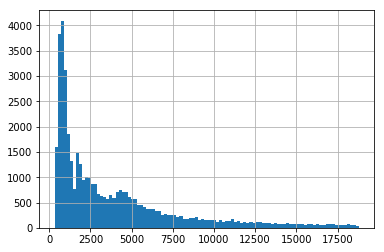

In [20]:
df_diamonds['price'].hist(bins=100)

In [21]:
df_diamonds['price'].describe()

count    43136.000000
mean      3926.531459
std       3983.079043
min        326.000000
25%        950.750000
50%       2398.000000
75%       5330.000000
max      18806.000000
Name: price, dtype: float64

## SGD Regression For Fun


In [22]:
cat_columns = df_diamonds.select_dtypes(['category']).columns.values
df_diamonds[cat_columns] = df_diamonds[cat_columns].apply(lambda x: x.cat.codes)



## Normalizing the Data
Using the robust scaller **to not only use the mean normalization**, but also to be less vulnerable to outliers.

In [23]:
X  = df_diamonds.copy()
y = X.pop('price')
scaler = RobustScaler()
scaler.fit(X)
X = scaler.transform(X)


## Regression
Since there is no negative values in the prices we are using here the log(price) to maintain this domain during the regression train. 
We are also using a 5 cross fold validation to do the grid search. 

A validation set was extracted from the data as a simulation for the test set.


In [24]:
from sklearn.model_selection import *

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.1, random_state=42)


In [25]:

    
def sklLinearRegressionModel(X_train,y_train,best_hyperparams):
	regression = linear_model.SGDRegressor(**best_hyperparams, penalty=None, verbose=True) 
	regression.fit(X_train, np.log(y_train))
	return regr


def crossValidationKFold(X_train,y_train):
	hyperparams = {
    	'learning_rate':['invscaling', 'optimal'],
    	'eta0': [0.1, 0.05, 0.01], 
    	'max_iter':[20000, 10000]
	}

	scoring = {
    	'NEG_MSE': 'neg_mean_squared_error',
    	'NEG_MAE': 'neg_mean_absolute_error',
    	'VARIANCE': 'r2'
	}

	regr = GridSearchCV(linear_model.SGDRegressor(), hyperparams, cv=5, scoring=scoring, refit='VARIANCE', n_jobs=-1, verbose=True)

	regr.fit(X_train, np.log(y_train))

	return regr.best_params_


best_hyperparams = {'learning_rate': 'invscaling', 'max_iter': 10000, 'eta0': 0.01}
regr = sklLinearRegressionModel(X_train,y_train,best_hyperparams)

-- Epoch 1
Norm: 0.95, NNZs: 11, Bias: 7.676084, T: 38822, Avg. loss: 0.180065
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1.16, NNZs: 11, Bias: 7.746769, T: 77644, Avg. loss: 0.034196
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.33, NNZs: 11, Bias: 7.770052, T: 116466, Avg. loss: 0.031170
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.41, NNZs: 11, Bias: 7.781925, T: 155288, Avg. loss: 0.028541
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.46, NNZs: 11, Bias: 7.792355, T: 194110, Avg. loss: 0.027363
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1.49, NNZs: 11, Bias: 7.797621, T: 232932, Avg. loss: 0.027004
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 1.52, NNZs: 11, Bias: 7.802846, T: 271754, Avg. loss: 0.026860
Total training time: 0.08 seconds.
-- Epoch 8
Norm: 1.53, NNZs: 11, Bias: 7.806097, T: 310576, Avg. loss: 0.026780
Total training time: 0.09 seconds.
-- Epoch 9
Norm: 1.54, NNZs: 11, Bias: 7.806514, T: 349398, Avg. loss: 0.026729
To

Norm: 1.62, NNZs: 11, Bias: 7.812705, T: 2950472, Avg. loss: 0.026449
Total training time: 0.61 seconds.
-- Epoch 77
Norm: 1.62, NNZs: 11, Bias: 7.811145, T: 2989294, Avg. loss: 0.026463
Total training time: 0.62 seconds.
-- Epoch 78
Norm: 1.62, NNZs: 11, Bias: 7.812165, T: 3028116, Avg. loss: 0.026444
Total training time: 0.63 seconds.
-- Epoch 79
Norm: 1.62, NNZs: 11, Bias: 7.818271, T: 3066938, Avg. loss: 0.026441
Total training time: 0.63 seconds.
-- Epoch 80
Norm: 1.62, NNZs: 11, Bias: 7.815193, T: 3105760, Avg. loss: 0.026432
Total training time: 0.64 seconds.
-- Epoch 81
Norm: 1.63, NNZs: 11, Bias: 7.814617, T: 3144582, Avg. loss: 0.026455
Total training time: 0.65 seconds.
-- Epoch 82
Norm: 1.63, NNZs: 11, Bias: 7.814701, T: 3183404, Avg. loss: 0.026443
Total training time: 0.65 seconds.
-- Epoch 83
Norm: 1.63, NNZs: 11, Bias: 7.813621, T: 3222226, Avg. loss: 0.026455
Total training time: 0.66 seconds.
-- Epoch 84
Norm: 1.63, NNZs: 11, Bias: 7.817551, T: 3261048, Avg. loss: 0.0

Norm: 1.71, NNZs: 11, Bias: 7.819054, T: 6483274, Avg. loss: 0.026353
Total training time: 1.22 seconds.
-- Epoch 168
Norm: 1.71, NNZs: 11, Bias: 7.814176, T: 6522096, Avg. loss: 0.026355
Total training time: 1.23 seconds.
-- Epoch 169
Norm: 1.71, NNZs: 11, Bias: 7.813921, T: 6560918, Avg. loss: 0.026341
Total training time: 1.24 seconds.
-- Epoch 170
Norm: 1.71, NNZs: 11, Bias: 7.819704, T: 6599740, Avg. loss: 0.026349
Total training time: 1.24 seconds.
-- Epoch 171
Norm: 1.71, NNZs: 11, Bias: 7.815991, T: 6638562, Avg. loss: 0.026348
Total training time: 1.25 seconds.
-- Epoch 172
Norm: 1.71, NNZs: 11, Bias: 7.816719, T: 6677384, Avg. loss: 0.026350
Total training time: 1.26 seconds.
-- Epoch 173
Norm: 1.71, NNZs: 11, Bias: 7.814618, T: 6716206, Avg. loss: 0.026348
Total training time: 1.26 seconds.
-- Epoch 174
Norm: 1.71, NNZs: 11, Bias: 7.816154, T: 6755028, Avg. loss: 0.026348
Total training time: 1.27 seconds.
-- Epoch 175
Norm: 1.71, NNZs: 11, Bias: 7.810331, T: 6793850, Avg. l

Norm: 1.78, NNZs: 11, Bias: 7.815375, T: 10054898, Avg. loss: 0.026304
Total training time: 1.84 seconds.
-- Epoch 260
Norm: 1.78, NNZs: 11, Bias: 7.816479, T: 10093720, Avg. loss: 0.026301
Total training time: 1.84 seconds.
-- Epoch 261
Norm: 1.78, NNZs: 11, Bias: 7.815919, T: 10132542, Avg. loss: 0.026306
Total training time: 1.85 seconds.
-- Epoch 262
Norm: 1.78, NNZs: 11, Bias: 7.811392, T: 10171364, Avg. loss: 0.026299
Total training time: 1.86 seconds.
-- Epoch 263
Norm: 1.78, NNZs: 11, Bias: 7.816488, T: 10210186, Avg. loss: 0.026299
Total training time: 1.86 seconds.
-- Epoch 264
Norm: 1.78, NNZs: 11, Bias: 7.812798, T: 10249008, Avg. loss: 0.026298
Total training time: 1.87 seconds.
-- Epoch 265
Norm: 1.79, NNZs: 11, Bias: 7.818653, T: 10287830, Avg. loss: 0.026300
Total training time: 1.88 seconds.
-- Epoch 266
Norm: 1.78, NNZs: 11, Bias: 7.815226, T: 10326652, Avg. loss: 0.026298
Total training time: 1.88 seconds.
-- Epoch 267
Norm: 1.79, NNZs: 11, Bias: 7.817328, T: 1036547

Norm: 1.84, NNZs: 11, Bias: 7.817792, T: 13510056, Avg. loss: 0.026273
Total training time: 2.45 seconds.
-- Epoch 349
Norm: 1.84, NNZs: 11, Bias: 7.815913, T: 13548878, Avg. loss: 0.026279
Total training time: 2.46 seconds.
-- Epoch 350
Norm: 1.84, NNZs: 11, Bias: 7.819032, T: 13587700, Avg. loss: 0.026276
Total training time: 2.46 seconds.
-- Epoch 351
Norm: 1.84, NNZs: 11, Bias: 7.813448, T: 13626522, Avg. loss: 0.026276
Total training time: 2.47 seconds.
-- Epoch 352
Norm: 1.84, NNZs: 11, Bias: 7.814125, T: 13665344, Avg. loss: 0.026263
Total training time: 2.48 seconds.
-- Epoch 353
Norm: 1.84, NNZs: 11, Bias: 7.818816, T: 13704166, Avg. loss: 0.026275
Total training time: 2.49 seconds.
-- Epoch 354
Norm: 1.84, NNZs: 11, Bias: 7.814400, T: 13742988, Avg. loss: 0.026280
Total training time: 2.49 seconds.
-- Epoch 355
Norm: 1.84, NNZs: 11, Bias: 7.815448, T: 13781810, Avg. loss: 0.026271
Total training time: 2.50 seconds.
-- Epoch 356
Norm: 1.84, NNZs: 11, Bias: 7.817173, T: 1382063

Norm: 1.89, NNZs: 11, Bias: 7.817804, T: 17004036, Avg. loss: 0.026267
Total training time: 3.06 seconds.
-- Epoch 439
Norm: 1.89, NNZs: 11, Bias: 7.817631, T: 17042858, Avg. loss: 0.026261
Total training time: 3.07 seconds.
-- Epoch 440
Norm: 1.89, NNZs: 11, Bias: 7.818428, T: 17081680, Avg. loss: 0.026257
Total training time: 3.08 seconds.
-- Epoch 441
Norm: 1.89, NNZs: 11, Bias: 7.816405, T: 17120502, Avg. loss: 0.026263
Total training time: 3.08 seconds.
-- Epoch 442
Norm: 1.89, NNZs: 11, Bias: 7.816453, T: 17159324, Avg. loss: 0.026263
Total training time: 3.09 seconds.
-- Epoch 443
Norm: 1.89, NNZs: 11, Bias: 7.816961, T: 17198146, Avg. loss: 0.026263
Total training time: 3.10 seconds.
-- Epoch 444
Norm: 1.89, NNZs: 11, Bias: 7.817935, T: 17236968, Avg. loss: 0.026255
Total training time: 3.10 seconds.
-- Epoch 445
Norm: 1.89, NNZs: 11, Bias: 7.816062, T: 17275790, Avg. loss: 0.026261
Total training time: 3.11 seconds.
-- Epoch 446
Norm: 1.89, NNZs: 11, Bias: 7.816401, T: 1731461

Norm: 1.93, NNZs: 11, Bias: 7.818588, T: 20614482, Avg. loss: 0.026247
Total training time: 3.68 seconds.
-- Epoch 532
Norm: 1.93, NNZs: 11, Bias: 7.817757, T: 20653304, Avg. loss: 0.026251
Total training time: 3.69 seconds.
-- Epoch 533
Norm: 1.93, NNZs: 11, Bias: 7.817226, T: 20692126, Avg. loss: 0.026247
Total training time: 3.69 seconds.
-- Epoch 534
Norm: 1.93, NNZs: 11, Bias: 7.816440, T: 20730948, Avg. loss: 0.026253
Total training time: 3.70 seconds.
-- Epoch 535
Norm: 1.93, NNZs: 11, Bias: 7.817731, T: 20769770, Avg. loss: 0.026251
Total training time: 3.70 seconds.
-- Epoch 536
Norm: 1.93, NNZs: 11, Bias: 7.819364, T: 20808592, Avg. loss: 0.026250
Total training time: 3.71 seconds.
-- Epoch 537
Norm: 1.93, NNZs: 11, Bias: 7.815430, T: 20847414, Avg. loss: 0.026250
Total training time: 3.72 seconds.
-- Epoch 538
Norm: 1.93, NNZs: 11, Bias: 7.818027, T: 20886236, Avg. loss: 0.026251
Total training time: 3.72 seconds.
-- Epoch 539
Norm: 1.93, NNZs: 11, Bias: 7.817110, T: 2092505

Norm: 1.96, NNZs: 11, Bias: 7.818973, T: 24186106, Avg. loss: 0.026244
Total training time: 4.29 seconds.
-- Epoch 624
Norm: 1.96, NNZs: 11, Bias: 7.818124, T: 24224928, Avg. loss: 0.026241
Total training time: 4.29 seconds.
-- Epoch 625
Norm: 1.96, NNZs: 11, Bias: 7.819015, T: 24263750, Avg. loss: 0.026243
Total training time: 4.30 seconds.
-- Epoch 626
Norm: 1.96, NNZs: 11, Bias: 7.818441, T: 24302572, Avg. loss: 0.026247
Total training time: 4.31 seconds.
-- Epoch 627
Norm: 1.96, NNZs: 11, Bias: 7.815869, T: 24341394, Avg. loss: 0.026241
Total training time: 4.31 seconds.
-- Epoch 628
Norm: 1.96, NNZs: 11, Bias: 7.818468, T: 24380216, Avg. loss: 0.026248
Total training time: 4.32 seconds.
-- Epoch 629
Norm: 1.96, NNZs: 11, Bias: 7.817357, T: 24419038, Avg. loss: 0.026243
Total training time: 4.33 seconds.
-- Epoch 630
Norm: 1.96, NNZs: 11, Bias: 7.819729, T: 24457860, Avg. loss: 0.026237
Total training time: 4.34 seconds.
-- Epoch 631
Norm: 1.96, NNZs: 11, Bias: 7.818059, T: 2449668

Norm: 1.98, NNZs: 11, Bias: 7.817977, T: 27680086, Avg. loss: 0.026242
Total training time: 4.90 seconds.
-- Epoch 714
Norm: 1.98, NNZs: 11, Bias: 7.814588, T: 27718908, Avg. loss: 0.026234
Total training time: 4.90 seconds.
-- Epoch 715
Norm: 1.98, NNZs: 11, Bias: 7.820502, T: 27757730, Avg. loss: 0.026241
Total training time: 4.91 seconds.
-- Epoch 716
Norm: 1.98, NNZs: 11, Bias: 7.816796, T: 27796552, Avg. loss: 0.026240
Total training time: 4.92 seconds.
-- Epoch 717
Norm: 1.98, NNZs: 11, Bias: 7.819403, T: 27835374, Avg. loss: 0.026238
Total training time: 4.92 seconds.
-- Epoch 718
Norm: 1.98, NNZs: 11, Bias: 7.817503, T: 27874196, Avg. loss: 0.026235
Total training time: 4.93 seconds.
-- Epoch 719
Norm: 1.98, NNZs: 11, Bias: 7.818269, T: 27913018, Avg. loss: 0.026233
Total training time: 4.94 seconds.
-- Epoch 720
Norm: 1.98, NNZs: 11, Bias: 7.817439, T: 27951840, Avg. loss: 0.026244
Total training time: 4.94 seconds.
-- Epoch 721
Norm: 1.98, NNZs: 11, Bias: 7.816983, T: 2799066

Norm: 2.00, NNZs: 11, Bias: 7.817310, T: 31212888, Avg. loss: 0.026239
Total training time: 5.51 seconds.
-- Epoch 805
Norm: 2.00, NNZs: 11, Bias: 7.815130, T: 31251710, Avg. loss: 0.026231
Total training time: 5.52 seconds.
-- Epoch 806
Norm: 2.00, NNZs: 11, Bias: 7.819533, T: 31290532, Avg. loss: 0.026237
Total training time: 5.53 seconds.
-- Epoch 807
Norm: 2.00, NNZs: 11, Bias: 7.820134, T: 31329354, Avg. loss: 0.026230
Total training time: 5.53 seconds.
-- Epoch 808
Norm: 2.00, NNZs: 11, Bias: 7.818755, T: 31368176, Avg. loss: 0.026238
Total training time: 5.54 seconds.
-- Epoch 809
Norm: 2.00, NNZs: 11, Bias: 7.814707, T: 31406998, Avg. loss: 0.026237
Total training time: 5.55 seconds.
-- Epoch 810
Norm: 2.00, NNZs: 11, Bias: 7.817871, T: 31445820, Avg. loss: 0.026238
Total training time: 5.56 seconds.
-- Epoch 811
Norm: 2.00, NNZs: 11, Bias: 7.815458, T: 31484642, Avg. loss: 0.026236
Total training time: 5.56 seconds.
-- Epoch 812
Norm: 2.00, NNZs: 11, Bias: 7.816440, T: 3152346

Norm: 2.02, NNZs: 11, Bias: 7.817696, T: 34629224, Avg. loss: 0.026238
Total training time: 6.12 seconds.
-- Epoch 893
Norm: 2.02, NNZs: 11, Bias: 7.816631, T: 34668046, Avg. loss: 0.026234
Total training time: 6.13 seconds.
-- Epoch 894
Norm: 2.02, NNZs: 11, Bias: 7.816964, T: 34706868, Avg. loss: 0.026231
Total training time: 6.14 seconds.
-- Epoch 895
Norm: 2.02, NNZs: 11, Bias: 7.816668, T: 34745690, Avg. loss: 0.026237
Total training time: 6.14 seconds.
-- Epoch 896
Norm: 2.02, NNZs: 11, Bias: 7.818006, T: 34784512, Avg. loss: 0.026235
Total training time: 6.15 seconds.
-- Epoch 897
Norm: 2.02, NNZs: 11, Bias: 7.820839, T: 34823334, Avg. loss: 0.026235
Total training time: 6.16 seconds.
-- Epoch 898
Norm: 2.02, NNZs: 11, Bias: 7.817578, T: 34862156, Avg. loss: 0.026231
Total training time: 6.17 seconds.
-- Epoch 899
Norm: 2.02, NNZs: 11, Bias: 7.816870, T: 34900978, Avg. loss: 0.026238
Total training time: 6.17 seconds.
-- Epoch 900
Norm: 2.02, NNZs: 11, Bias: 7.818134, T: 3493980

Norm: 2.03, NNZs: 11, Bias: 7.816189, T: 38084382, Avg. loss: 0.026238
Total training time: 6.74 seconds.
-- Epoch 982
Norm: 2.03, NNZs: 11, Bias: 7.817569, T: 38123204, Avg. loss: 0.026235
Total training time: 6.75 seconds.
-- Epoch 983
Norm: 2.03, NNZs: 11, Bias: 7.819484, T: 38162026, Avg. loss: 0.026234
Total training time: 6.75 seconds.
-- Epoch 984
Norm: 2.03, NNZs: 11, Bias: 7.817606, T: 38200848, Avg. loss: 0.026237
Total training time: 6.76 seconds.
-- Epoch 985
Norm: 2.03, NNZs: 11, Bias: 7.817142, T: 38239670, Avg. loss: 0.026230
Total training time: 6.77 seconds.
-- Epoch 986
Norm: 2.03, NNZs: 11, Bias: 7.815143, T: 38278492, Avg. loss: 0.026234
Total training time: 6.77 seconds.
-- Epoch 987
Norm: 2.03, NNZs: 11, Bias: 7.817540, T: 38317314, Avg. loss: 0.026234
Total training time: 6.78 seconds.
-- Epoch 988
Norm: 2.03, NNZs: 11, Bias: 7.818323, T: 38356136, Avg. loss: 0.026231
Total training time: 6.79 seconds.
-- Epoch 989
Norm: 2.03, NNZs: 11, Bias: 7.817291, T: 3839495

Norm: 2.04, NNZs: 11, Bias: 7.816255, T: 41539540, Avg. loss: 0.026234
Total training time: 7.35 seconds.
-- Epoch 1071
Norm: 2.04, NNZs: 11, Bias: 7.818008, T: 41578362, Avg. loss: 0.026232
Total training time: 7.36 seconds.
-- Epoch 1072
Norm: 2.04, NNZs: 11, Bias: 7.817134, T: 41617184, Avg. loss: 0.026236
Total training time: 7.36 seconds.
-- Epoch 1073
Norm: 2.04, NNZs: 11, Bias: 7.819565, T: 41656006, Avg. loss: 0.026234
Total training time: 7.37 seconds.
-- Epoch 1074
Norm: 2.04, NNZs: 11, Bias: 7.819817, T: 41694828, Avg. loss: 0.026234
Total training time: 7.38 seconds.
-- Epoch 1075
Norm: 2.04, NNZs: 11, Bias: 7.814999, T: 41733650, Avg. loss: 0.026228
Total training time: 7.39 seconds.
-- Epoch 1076
Norm: 2.04, NNZs: 11, Bias: 7.817883, T: 41772472, Avg. loss: 0.026233
Total training time: 7.39 seconds.
-- Epoch 1077
Norm: 2.04, NNZs: 11, Bias: 7.820803, T: 41811294, Avg. loss: 0.026233
Total training time: 7.40 seconds.
-- Epoch 1078
Norm: 2.04, NNZs: 11, Bias: 7.815606, T:

Norm: 2.05, NNZs: 11, Bias: 7.820794, T: 44994698, Avg. loss: 0.026235
Total training time: 7.96 seconds.
-- Epoch 1160
Norm: 2.05, NNZs: 11, Bias: 7.815775, T: 45033520, Avg. loss: 0.026236
Total training time: 7.97 seconds.
-- Epoch 1161
Norm: 2.05, NNZs: 11, Bias: 7.815983, T: 45072342, Avg. loss: 0.026230
Total training time: 7.97 seconds.
-- Epoch 1162
Norm: 2.05, NNZs: 11, Bias: 7.819831, T: 45111164, Avg. loss: 0.026236
Total training time: 7.98 seconds.
-- Epoch 1163
Norm: 2.05, NNZs: 11, Bias: 7.815988, T: 45149986, Avg. loss: 0.026231
Total training time: 7.99 seconds.
-- Epoch 1164
Norm: 2.05, NNZs: 11, Bias: 7.818461, T: 45188808, Avg. loss: 0.026225
Total training time: 7.99 seconds.
-- Epoch 1165
Norm: 2.05, NNZs: 11, Bias: 7.818438, T: 45227630, Avg. loss: 0.026237
Total training time: 8.00 seconds.
-- Epoch 1166
Norm: 2.05, NNZs: 11, Bias: 7.818760, T: 45266452, Avg. loss: 0.026236
Total training time: 8.01 seconds.
-- Epoch 1167
Norm: 2.05, NNZs: 11, Bias: 7.819136, T:

Norm: 2.06, NNZs: 11, Bias: 7.817848, T: 48372212, Avg. loss: 0.026226
Total training time: 8.57 seconds.
-- Epoch 1247
Norm: 2.06, NNZs: 11, Bias: 7.820293, T: 48411034, Avg. loss: 0.026232
Total training time: 8.58 seconds.
-- Epoch 1248
Norm: 2.06, NNZs: 11, Bias: 7.818669, T: 48449856, Avg. loss: 0.026228
Total training time: 8.59 seconds.
-- Epoch 1249
Norm: 2.06, NNZs: 11, Bias: 7.816329, T: 48488678, Avg. loss: 0.026230
Total training time: 8.59 seconds.
-- Epoch 1250
Norm: 2.06, NNZs: 11, Bias: 7.819298, T: 48527500, Avg. loss: 0.026234
Total training time: 8.60 seconds.
-- Epoch 1251
Norm: 2.06, NNZs: 11, Bias: 7.818650, T: 48566322, Avg. loss: 0.026227
Total training time: 8.61 seconds.
-- Epoch 1252
Norm: 2.06, NNZs: 11, Bias: 7.816213, T: 48605144, Avg. loss: 0.026233
Total training time: 8.61 seconds.
-- Epoch 1253
Norm: 2.06, NNZs: 11, Bias: 7.816936, T: 48643966, Avg. loss: 0.026227
Total training time: 8.62 seconds.
-- Epoch 1254
Norm: 2.06, NNZs: 11, Bias: 7.816890, T:

Norm: 2.07, NNZs: 11, Bias: 7.819689, T: 52021480, Avg. loss: 0.026230
Total training time: 9.19 seconds.
-- Epoch 1341
Norm: 2.07, NNZs: 11, Bias: 7.818001, T: 52060302, Avg. loss: 0.026234
Total training time: 9.19 seconds.
-- Epoch 1342
Norm: 2.07, NNZs: 11, Bias: 7.819985, T: 52099124, Avg. loss: 0.026232
Total training time: 9.20 seconds.
-- Epoch 1343
Norm: 2.07, NNZs: 11, Bias: 7.817510, T: 52137946, Avg. loss: 0.026224
Total training time: 9.21 seconds.
-- Epoch 1344
Norm: 2.07, NNZs: 11, Bias: 7.818073, T: 52176768, Avg. loss: 0.026235
Total training time: 9.21 seconds.
-- Epoch 1345
Norm: 2.07, NNZs: 11, Bias: 7.817102, T: 52215590, Avg. loss: 0.026228
Total training time: 9.22 seconds.
-- Epoch 1346
Norm: 2.07, NNZs: 11, Bias: 7.818566, T: 52254412, Avg. loss: 0.026230
Total training time: 9.23 seconds.
-- Epoch 1347
Norm: 2.07, NNZs: 11, Bias: 7.816911, T: 52293234, Avg. loss: 0.026231
Total training time: 9.23 seconds.
-- Epoch 1348
Norm: 2.07, NNZs: 11, Bias: 7.819292, T:

Norm: 2.07, NNZs: 11, Bias: 7.818421, T: 55554282, Avg. loss: 0.026231
Total training time: 9.80 seconds.
-- Epoch 1432
Norm: 2.07, NNZs: 11, Bias: 7.817288, T: 55593104, Avg. loss: 0.026230
Total training time: 9.81 seconds.
-- Epoch 1433
Norm: 2.07, NNZs: 11, Bias: 7.817474, T: 55631926, Avg. loss: 0.026231
Total training time: 9.82 seconds.
-- Epoch 1434
Norm: 2.07, NNZs: 11, Bias: 7.818592, T: 55670748, Avg. loss: 0.026228
Total training time: 9.82 seconds.
-- Epoch 1435
Norm: 2.07, NNZs: 11, Bias: 7.816486, T: 55709570, Avg. loss: 0.026232
Total training time: 9.83 seconds.
-- Epoch 1436
Norm: 2.07, NNZs: 11, Bias: 7.818248, T: 55748392, Avg. loss: 0.026232
Total training time: 9.84 seconds.
-- Epoch 1437
Norm: 2.07, NNZs: 11, Bias: 7.817651, T: 55787214, Avg. loss: 0.026235
Total training time: 9.85 seconds.
-- Epoch 1438
Norm: 2.07, NNZs: 11, Bias: 7.817470, T: 55826036, Avg. loss: 0.026229
Total training time: 9.85 seconds.
-- Epoch 1439
Norm: 2.07, NNZs: 11, Bias: 7.816927, T:

Norm: 2.08, NNZs: 11, Bias: 7.816633, T: 59087084, Avg. loss: 0.026231
Total training time: 10.42 seconds.
-- Epoch 1523
Norm: 2.08, NNZs: 11, Bias: 7.819754, T: 59125906, Avg. loss: 0.026231
Total training time: 10.42 seconds.
-- Epoch 1524
Norm: 2.08, NNZs: 11, Bias: 7.816542, T: 59164728, Avg. loss: 0.026225
Total training time: 10.43 seconds.
-- Epoch 1525
Norm: 2.08, NNZs: 11, Bias: 7.818671, T: 59203550, Avg. loss: 0.026227
Total training time: 10.44 seconds.
-- Epoch 1526
Norm: 2.08, NNZs: 11, Bias: 7.820644, T: 59242372, Avg. loss: 0.026231
Total training time: 10.44 seconds.
-- Epoch 1527
Norm: 2.08, NNZs: 11, Bias: 7.819575, T: 59281194, Avg. loss: 0.026229
Total training time: 10.45 seconds.
-- Epoch 1528
Norm: 2.08, NNZs: 11, Bias: 7.819825, T: 59320016, Avg. loss: 0.026237
Total training time: 10.46 seconds.
-- Epoch 1529
Norm: 2.08, NNZs: 11, Bias: 7.817471, T: 59358838, Avg. loss: 0.026231
Total training time: 10.46 seconds.
-- Epoch 1530
Norm: 2.08, NNZs: 11, Bias: 7.81

Norm: 2.08, NNZs: 11, Bias: 7.820321, T: 62619886, Avg. loss: 0.026230
Total training time: 11.02 seconds.
-- Epoch 1614
Norm: 2.08, NNZs: 11, Bias: 7.818235, T: 62658708, Avg. loss: 0.026222
Total training time: 11.03 seconds.
-- Epoch 1615
Norm: 2.08, NNZs: 11, Bias: 7.815838, T: 62697530, Avg. loss: 0.026228
Total training time: 11.04 seconds.
-- Epoch 1616
Norm: 2.08, NNZs: 11, Bias: 7.819282, T: 62736352, Avg. loss: 0.026230
Total training time: 11.04 seconds.
-- Epoch 1617
Norm: 2.08, NNZs: 11, Bias: 7.817407, T: 62775174, Avg. loss: 0.026230
Total training time: 11.05 seconds.
-- Epoch 1618
Norm: 2.08, NNZs: 11, Bias: 7.820227, T: 62813996, Avg. loss: 0.026225
Total training time: 11.05 seconds.
-- Epoch 1619
Norm: 2.08, NNZs: 11, Bias: 7.818693, T: 62852818, Avg. loss: 0.026230
Total training time: 11.06 seconds.
-- Epoch 1620
Norm: 2.08, NNZs: 11, Bias: 7.819212, T: 62891640, Avg. loss: 0.026229
Total training time: 11.07 seconds.
-- Epoch 1621
Norm: 2.08, NNZs: 11, Bias: 7.81

Norm: 2.08, NNZs: 11, Bias: 7.818574, T: 66191510, Avg. loss: 0.026229
Total training time: 11.63 seconds.
-- Epoch 1706
Norm: 2.08, NNZs: 11, Bias: 7.815500, T: 66230332, Avg. loss: 0.026231
Total training time: 11.64 seconds.
-- Epoch 1707
Norm: 2.08, NNZs: 11, Bias: 7.817505, T: 66269154, Avg. loss: 0.026234
Total training time: 11.64 seconds.
-- Epoch 1708
Norm: 2.08, NNZs: 11, Bias: 7.818428, T: 66307976, Avg. loss: 0.026230
Total training time: 11.65 seconds.
-- Epoch 1709
Norm: 2.08, NNZs: 11, Bias: 7.817301, T: 66346798, Avg. loss: 0.026226
Total training time: 11.66 seconds.
-- Epoch 1710
Norm: 2.08, NNZs: 11, Bias: 7.818140, T: 66385620, Avg. loss: 0.026228
Total training time: 11.66 seconds.
-- Epoch 1711
Norm: 2.08, NNZs: 11, Bias: 7.818067, T: 66424442, Avg. loss: 0.026228
Total training time: 11.67 seconds.
-- Epoch 1712
Norm: 2.08, NNZs: 11, Bias: 7.818109, T: 66463264, Avg. loss: 0.026230
Total training time: 11.68 seconds.
-- Epoch 1713
Norm: 2.08, NNZs: 11, Bias: 7.81

Norm: 2.09, NNZs: 11, Bias: 7.818213, T: 69840778, Avg. loss: 0.026231
Total training time: 12.25 seconds.
-- Epoch 1800
Norm: 2.09, NNZs: 11, Bias: 7.816805, T: 69879600, Avg. loss: 0.026231
Total training time: 12.25 seconds.
-- Epoch 1801
Norm: 2.09, NNZs: 11, Bias: 7.817812, T: 69918422, Avg. loss: 0.026225
Total training time: 12.26 seconds.
-- Epoch 1802
Norm: 2.09, NNZs: 11, Bias: 7.818350, T: 69957244, Avg. loss: 0.026232
Total training time: 12.27 seconds.
-- Epoch 1803
Norm: 2.09, NNZs: 11, Bias: 7.817898, T: 69996066, Avg. loss: 0.026228
Total training time: 12.27 seconds.
-- Epoch 1804
Norm: 2.09, NNZs: 11, Bias: 7.818742, T: 70034888, Avg. loss: 0.026231
Total training time: 12.28 seconds.
-- Epoch 1805
Norm: 2.09, NNZs: 11, Bias: 7.818334, T: 70073710, Avg. loss: 0.026229
Total training time: 12.29 seconds.
-- Epoch 1806
Norm: 2.09, NNZs: 11, Bias: 7.817194, T: 70112532, Avg. loss: 0.026227
Total training time: 12.29 seconds.
-- Epoch 1807
Norm: 2.09, NNZs: 11, Bias: 7.81

Norm: 2.09, NNZs: 11, Bias: 7.817813, T: 73451224, Avg. loss: 0.026231
Total training time: 12.86 seconds.
-- Epoch 1893
Norm: 2.09, NNZs: 11, Bias: 7.817852, T: 73490046, Avg. loss: 0.026231
Total training time: 12.87 seconds.
-- Epoch 1894
Norm: 2.09, NNZs: 11, Bias: 7.817192, T: 73528868, Avg. loss: 0.026227
Total training time: 12.87 seconds.
-- Epoch 1895
Norm: 2.09, NNZs: 11, Bias: 7.818096, T: 73567690, Avg. loss: 0.026228
Total training time: 12.88 seconds.
-- Epoch 1896
Norm: 2.09, NNZs: 11, Bias: 7.818255, T: 73606512, Avg. loss: 0.026232
Total training time: 12.89 seconds.
-- Epoch 1897
Norm: 2.09, NNZs: 11, Bias: 7.819309, T: 73645334, Avg. loss: 0.026230
Total training time: 12.89 seconds.
-- Epoch 1898
Norm: 2.09, NNZs: 11, Bias: 7.816926, T: 73684156, Avg. loss: 0.026227
Total training time: 12.90 seconds.
-- Epoch 1899
Norm: 2.09, NNZs: 11, Bias: 7.817865, T: 73722978, Avg. loss: 0.026231
Total training time: 12.91 seconds.
-- Epoch 1900
Norm: 2.09, NNZs: 11, Bias: 7.81

Norm: 2.09, NNZs: 11, Bias: 7.819975, T: 76984026, Avg. loss: 0.026230
Total training time: 13.47 seconds.
-- Epoch 1984
Norm: 2.09, NNZs: 11, Bias: 7.818156, T: 77022848, Avg. loss: 0.026231
Total training time: 13.48 seconds.
-- Epoch 1985
Norm: 2.09, NNZs: 11, Bias: 7.819939, T: 77061670, Avg. loss: 0.026228
Total training time: 13.48 seconds.
-- Epoch 1986
Norm: 2.09, NNZs: 11, Bias: 7.819233, T: 77100492, Avg. loss: 0.026231
Total training time: 13.49 seconds.
-- Epoch 1987
Norm: 2.09, NNZs: 11, Bias: 7.817819, T: 77139314, Avg. loss: 0.026225
Total training time: 13.50 seconds.
-- Epoch 1988
Norm: 2.09, NNZs: 11, Bias: 7.816453, T: 77178136, Avg. loss: 0.026229
Total training time: 13.50 seconds.
-- Epoch 1989
Norm: 2.09, NNZs: 11, Bias: 7.818185, T: 77216958, Avg. loss: 0.026230
Total training time: 13.51 seconds.
-- Epoch 1990
Norm: 2.09, NNZs: 11, Bias: 7.818968, T: 77255780, Avg. loss: 0.026231
Total training time: 13.52 seconds.
-- Epoch 1991
Norm: 2.09, NNZs: 11, Bias: 7.81

Norm: 2.09, NNZs: 11, Bias: 7.818982, T: 80710938, Avg. loss: 0.026227
Total training time: 14.09 seconds.
-- Epoch 2080
Norm: 2.09, NNZs: 11, Bias: 7.818474, T: 80749760, Avg. loss: 0.026229
Total training time: 14.10 seconds.
-- Epoch 2081
Norm: 2.09, NNZs: 11, Bias: 7.817622, T: 80788582, Avg. loss: 0.026228
Total training time: 14.10 seconds.
-- Epoch 2082
Norm: 2.09, NNZs: 11, Bias: 7.819340, T: 80827404, Avg. loss: 0.026228
Total training time: 14.11 seconds.
-- Epoch 2083
Norm: 2.09, NNZs: 11, Bias: 7.817733, T: 80866226, Avg. loss: 0.026230
Total training time: 14.12 seconds.
-- Epoch 2084
Norm: 2.09, NNZs: 11, Bias: 7.818149, T: 80905048, Avg. loss: 0.026233
Total training time: 14.12 seconds.
-- Epoch 2085
Norm: 2.09, NNZs: 11, Bias: 7.817705, T: 80943870, Avg. loss: 0.026223
Total training time: 14.13 seconds.
-- Epoch 2086
Norm: 2.09, NNZs: 11, Bias: 7.818288, T: 80982692, Avg. loss: 0.026232
Total training time: 14.13 seconds.
-- Epoch 2087
Norm: 2.09, NNZs: 11, Bias: 7.81

Norm: 2.09, NNZs: 11, Bias: 7.818944, T: 84282562, Avg. loss: 0.026230
Total training time: 14.70 seconds.
-- Epoch 2172
Norm: 2.09, NNZs: 11, Bias: 7.820102, T: 84321384, Avg. loss: 0.026227
Total training time: 14.70 seconds.
-- Epoch 2173
Norm: 2.09, NNZs: 11, Bias: 7.818771, T: 84360206, Avg. loss: 0.026232
Total training time: 14.71 seconds.
-- Epoch 2174
Norm: 2.09, NNZs: 11, Bias: 7.815771, T: 84399028, Avg. loss: 0.026227
Total training time: 14.72 seconds.
-- Epoch 2175
Norm: 2.09, NNZs: 11, Bias: 7.816606, T: 84437850, Avg. loss: 0.026227
Total training time: 14.72 seconds.
-- Epoch 2176
Norm: 2.09, NNZs: 11, Bias: 7.818464, T: 84476672, Avg. loss: 0.026229
Total training time: 14.73 seconds.
-- Epoch 2177
Norm: 2.09, NNZs: 11, Bias: 7.817139, T: 84515494, Avg. loss: 0.026224
Total training time: 14.74 seconds.
-- Epoch 2178
Norm: 2.09, NNZs: 11, Bias: 7.818927, T: 84554316, Avg. loss: 0.026230
Total training time: 14.74 seconds.
-- Epoch 2179
Norm: 2.09, NNZs: 11, Bias: 7.81

Norm: 2.10, NNZs: 11, Bias: 7.818201, T: 87931830, Avg. loss: 0.026231
Total training time: 15.31 seconds.
-- Epoch 2266
Norm: 2.09, NNZs: 11, Bias: 7.819794, T: 87970652, Avg. loss: 0.026225
Total training time: 15.32 seconds.
-- Epoch 2267
Norm: 2.09, NNZs: 11, Bias: 7.819473, T: 88009474, Avg. loss: 0.026228
Total training time: 15.32 seconds.
-- Epoch 2268
Norm: 2.09, NNZs: 11, Bias: 7.816790, T: 88048296, Avg. loss: 0.026228
Total training time: 15.33 seconds.
-- Epoch 2269
Norm: 2.10, NNZs: 11, Bias: 7.818081, T: 88087118, Avg. loss: 0.026231
Total training time: 15.34 seconds.
-- Epoch 2270
Norm: 2.10, NNZs: 11, Bias: 7.819239, T: 88125940, Avg. loss: 0.026229
Total training time: 15.34 seconds.
-- Epoch 2271
Norm: 2.10, NNZs: 11, Bias: 7.816531, T: 88164762, Avg. loss: 0.026228
Total training time: 15.35 seconds.
-- Epoch 2272
Norm: 2.10, NNZs: 11, Bias: 7.815486, T: 88203584, Avg. loss: 0.026228
Total training time: 15.36 seconds.
-- Epoch 2273
Norm: 2.10, NNZs: 11, Bias: 7.81

Norm: 2.10, NNZs: 11, Bias: 7.820505, T: 91503454, Avg. loss: 0.026227
Total training time: 15.92 seconds.
-- Epoch 2358
Norm: 2.10, NNZs: 11, Bias: 7.817794, T: 91542276, Avg. loss: 0.026228
Total training time: 15.93 seconds.
-- Epoch 2359
Norm: 2.10, NNZs: 11, Bias: 7.817725, T: 91581098, Avg. loss: 0.026231
Total training time: 15.93 seconds.
-- Epoch 2360
Norm: 2.10, NNZs: 11, Bias: 7.817339, T: 91619920, Avg. loss: 0.026230
Total training time: 15.94 seconds.
-- Epoch 2361
Norm: 2.10, NNZs: 11, Bias: 7.817795, T: 91658742, Avg. loss: 0.026226
Total training time: 15.95 seconds.
-- Epoch 2362
Norm: 2.10, NNZs: 11, Bias: 7.818487, T: 91697564, Avg. loss: 0.026230
Total training time: 15.95 seconds.
-- Epoch 2363
Norm: 2.10, NNZs: 11, Bias: 7.817050, T: 91736386, Avg. loss: 0.026226
Total training time: 15.96 seconds.
-- Epoch 2364
Norm: 2.10, NNZs: 11, Bias: 7.818031, T: 91775208, Avg. loss: 0.026230
Total training time: 15.96 seconds.
-- Epoch 2365
Norm: 2.10, NNZs: 11, Bias: 7.81

Norm: 2.10, NNZs: 11, Bias: 7.815901, T: 95113900, Avg. loss: 0.026225
Total training time: 16.53 seconds.
-- Epoch 2451
Norm: 2.10, NNZs: 11, Bias: 7.821214, T: 95152722, Avg. loss: 0.026225
Total training time: 16.54 seconds.
-- Epoch 2452
Norm: 2.10, NNZs: 11, Bias: 7.819586, T: 95191544, Avg. loss: 0.026229
Total training time: 16.54 seconds.
-- Epoch 2453
Norm: 2.10, NNZs: 11, Bias: 7.819815, T: 95230366, Avg. loss: 0.026226
Total training time: 16.55 seconds.
-- Epoch 2454
Norm: 2.10, NNZs: 11, Bias: 7.818565, T: 95269188, Avg. loss: 0.026231
Total training time: 16.56 seconds.
-- Epoch 2455
Norm: 2.10, NNZs: 11, Bias: 7.817745, T: 95308010, Avg. loss: 0.026225
Total training time: 16.56 seconds.
-- Epoch 2456
Norm: 2.10, NNZs: 11, Bias: 7.818005, T: 95346832, Avg. loss: 0.026227
Total training time: 16.57 seconds.
-- Epoch 2457
Norm: 2.10, NNZs: 11, Bias: 7.818671, T: 95385654, Avg. loss: 0.026227
Total training time: 16.58 seconds.
-- Epoch 2458
Norm: 2.10, NNZs: 11, Bias: 7.81

Norm: 2.10, NNZs: 11, Bias: 7.818149, T: 98569058, Avg. loss: 0.026228
Total training time: 17.14 seconds.
-- Epoch 2540
Norm: 2.10, NNZs: 11, Bias: 7.817083, T: 98607880, Avg. loss: 0.026226
Total training time: 17.15 seconds.
-- Epoch 2541
Norm: 2.10, NNZs: 11, Bias: 7.818110, T: 98646702, Avg. loss: 0.026231
Total training time: 17.15 seconds.
-- Epoch 2542
Norm: 2.10, NNZs: 11, Bias: 7.819417, T: 98685524, Avg. loss: 0.026229
Total training time: 17.16 seconds.
-- Epoch 2543
Norm: 2.10, NNZs: 11, Bias: 7.817780, T: 98724346, Avg. loss: 0.026227
Total training time: 17.17 seconds.
-- Epoch 2544
Norm: 2.10, NNZs: 11, Bias: 7.818223, T: 98763168, Avg. loss: 0.026222
Total training time: 17.18 seconds.
-- Epoch 2545
Norm: 2.10, NNZs: 11, Bias: 7.817746, T: 98801990, Avg. loss: 0.026235
Total training time: 17.18 seconds.
-- Epoch 2546
Norm: 2.10, NNZs: 11, Bias: 7.818483, T: 98840812, Avg. loss: 0.026226
Total training time: 17.19 seconds.
-- Epoch 2547
Norm: 2.10, NNZs: 11, Bias: 7.82

Norm: 2.10, NNZs: 11, Bias: 7.817561, T: 101985394, Avg. loss: 0.026227
Total training time: 17.76 seconds.
-- Epoch 2628
Norm: 2.10, NNZs: 11, Bias: 7.818143, T: 102024216, Avg. loss: 0.026229
Total training time: 17.76 seconds.
-- Epoch 2629
Norm: 2.10, NNZs: 11, Bias: 7.817705, T: 102063038, Avg. loss: 0.026228
Total training time: 17.77 seconds.
-- Epoch 2630
Norm: 2.10, NNZs: 11, Bias: 7.819720, T: 102101860, Avg. loss: 0.026227
Total training time: 17.78 seconds.
-- Epoch 2631
Norm: 2.10, NNZs: 11, Bias: 7.817410, T: 102140682, Avg. loss: 0.026226
Total training time: 17.78 seconds.
-- Epoch 2632
Norm: 2.10, NNZs: 11, Bias: 7.820746, T: 102179504, Avg. loss: 0.026226
Total training time: 17.79 seconds.
-- Epoch 2633
Norm: 2.10, NNZs: 11, Bias: 7.818865, T: 102218326, Avg. loss: 0.026229
Total training time: 17.79 seconds.
-- Epoch 2634
Norm: 2.10, NNZs: 11, Bias: 7.817782, T: 102257148, Avg. loss: 0.026224
Total training time: 17.80 seconds.
-- Epoch 2635
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.816323, T: 105673484, Avg. loss: 0.026228
Total training time: 18.37 seconds.
-- Epoch 2723
Norm: 2.10, NNZs: 11, Bias: 7.818821, T: 105712306, Avg. loss: 0.026228
Total training time: 18.38 seconds.
-- Epoch 2724
Norm: 2.10, NNZs: 11, Bias: 7.820227, T: 105751128, Avg. loss: 0.026224
Total training time: 18.39 seconds.
-- Epoch 2725
Norm: 2.10, NNZs: 11, Bias: 7.818781, T: 105789950, Avg. loss: 0.026227
Total training time: 18.39 seconds.
-- Epoch 2726
Norm: 2.10, NNZs: 11, Bias: 7.817957, T: 105828772, Avg. loss: 0.026228
Total training time: 18.40 seconds.
-- Epoch 2727
Norm: 2.10, NNZs: 11, Bias: 7.818138, T: 105867594, Avg. loss: 0.026229
Total training time: 18.41 seconds.
-- Epoch 2728
Norm: 2.10, NNZs: 11, Bias: 7.818953, T: 105906416, Avg. loss: 0.026230
Total training time: 18.41 seconds.
-- Epoch 2729
Norm: 2.10, NNZs: 11, Bias: 7.819470, T: 105945238, Avg. loss: 0.026230
Total training time: 18.42 seconds.
-- Epoch 2730
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.816566, T: 109167464, Avg. loss: 0.026231
Total training time: 18.98 seconds.
-- Epoch 2813
Norm: 2.10, NNZs: 11, Bias: 7.818618, T: 109206286, Avg. loss: 0.026229
Total training time: 18.99 seconds.
-- Epoch 2814
Norm: 2.10, NNZs: 11, Bias: 7.818569, T: 109245108, Avg. loss: 0.026229
Total training time: 19.00 seconds.
-- Epoch 2815
Norm: 2.10, NNZs: 11, Bias: 7.817865, T: 109283930, Avg. loss: 0.026231
Total training time: 19.00 seconds.
-- Epoch 2816
Norm: 2.10, NNZs: 11, Bias: 7.817192, T: 109322752, Avg. loss: 0.026222
Total training time: 19.01 seconds.
-- Epoch 2817
Norm: 2.10, NNZs: 11, Bias: 7.819028, T: 109361574, Avg. loss: 0.026230
Total training time: 19.02 seconds.
-- Epoch 2818
Norm: 2.10, NNZs: 11, Bias: 7.816599, T: 109400396, Avg. loss: 0.026229
Total training time: 19.02 seconds.
-- Epoch 2819
Norm: 2.10, NNZs: 11, Bias: 7.817091, T: 109439218, Avg. loss: 0.026227
Total training time: 19.03 seconds.
-- Epoch 2820
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.816615, T: 112739088, Avg. loss: 0.026227
Total training time: 19.60 seconds.
-- Epoch 2905
Norm: 2.10, NNZs: 11, Bias: 7.817919, T: 112777910, Avg. loss: 0.026230
Total training time: 19.61 seconds.
-- Epoch 2906
Norm: 2.10, NNZs: 11, Bias: 7.817117, T: 112816732, Avg. loss: 0.026227
Total training time: 19.61 seconds.
-- Epoch 2907
Norm: 2.10, NNZs: 11, Bias: 7.819441, T: 112855554, Avg. loss: 0.026227
Total training time: 19.62 seconds.
-- Epoch 2908
Norm: 2.10, NNZs: 11, Bias: 7.819753, T: 112894376, Avg. loss: 0.026226
Total training time: 19.62 seconds.
-- Epoch 2909
Norm: 2.10, NNZs: 11, Bias: 7.817523, T: 112933198, Avg. loss: 0.026229
Total training time: 19.63 seconds.
-- Epoch 2910
Norm: 2.10, NNZs: 11, Bias: 7.817634, T: 112972020, Avg. loss: 0.026228
Total training time: 19.64 seconds.
-- Epoch 2911
Norm: 2.10, NNZs: 11, Bias: 7.818354, T: 113010842, Avg. loss: 0.026228
Total training time: 19.64 seconds.
-- Epoch 2912
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.818754, T: 116388356, Avg. loss: 0.026226
Total training time: 20.21 seconds.
-- Epoch 2999
Norm: 2.10, NNZs: 11, Bias: 7.818632, T: 116427178, Avg. loss: 0.026230
Total training time: 20.22 seconds.
-- Epoch 3000
Norm: 2.10, NNZs: 11, Bias: 7.817643, T: 116466000, Avg. loss: 0.026229
Total training time: 20.23 seconds.
-- Epoch 3001
Norm: 2.10, NNZs: 11, Bias: 7.816578, T: 116504822, Avg. loss: 0.026225
Total training time: 20.23 seconds.
-- Epoch 3002
Norm: 2.10, NNZs: 11, Bias: 7.817924, T: 116543644, Avg. loss: 0.026229
Total training time: 20.24 seconds.
-- Epoch 3003
Norm: 2.10, NNZs: 11, Bias: 7.817746, T: 116582466, Avg. loss: 0.026225
Total training time: 20.25 seconds.
-- Epoch 3004
Norm: 2.10, NNZs: 11, Bias: 7.817931, T: 116621288, Avg. loss: 0.026231
Total training time: 20.26 seconds.
-- Epoch 3005
Norm: 2.10, NNZs: 11, Bias: 7.816874, T: 116660110, Avg. loss: 0.026229
Total training time: 20.26 seconds.
-- Epoch 3006
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.817771, T: 119843514, Avg. loss: 0.026227
Total training time: 20.82 seconds.
-- Epoch 3088
Norm: 2.10, NNZs: 11, Bias: 7.818137, T: 119882336, Avg. loss: 0.026228
Total training time: 20.83 seconds.
-- Epoch 3089
Norm: 2.10, NNZs: 11, Bias: 7.817688, T: 119921158, Avg. loss: 0.026223
Total training time: 20.84 seconds.
-- Epoch 3090
Norm: 2.10, NNZs: 11, Bias: 7.817042, T: 119959980, Avg. loss: 0.026224
Total training time: 20.84 seconds.
-- Epoch 3091
Norm: 2.10, NNZs: 11, Bias: 7.818330, T: 119998802, Avg. loss: 0.026228
Total training time: 20.85 seconds.
-- Epoch 3092
Norm: 2.10, NNZs: 11, Bias: 7.817745, T: 120037624, Avg. loss: 0.026229
Total training time: 20.86 seconds.
-- Epoch 3093
Norm: 2.10, NNZs: 11, Bias: 7.819217, T: 120076446, Avg. loss: 0.026226
Total training time: 20.86 seconds.
-- Epoch 3094
Norm: 2.10, NNZs: 11, Bias: 7.817493, T: 120115268, Avg. loss: 0.026228
Total training time: 20.87 seconds.
-- Epoch 3095
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.819696, T: 123376316, Avg. loss: 0.026227
Total training time: 21.44 seconds.
-- Epoch 3179
Norm: 2.10, NNZs: 11, Bias: 7.817113, T: 123415138, Avg. loss: 0.026228
Total training time: 21.44 seconds.
-- Epoch 3180
Norm: 2.10, NNZs: 11, Bias: 7.817729, T: 123453960, Avg. loss: 0.026230
Total training time: 21.45 seconds.
-- Epoch 3181
Norm: 2.10, NNZs: 11, Bias: 7.818575, T: 123492782, Avg. loss: 0.026230
Total training time: 21.46 seconds.
-- Epoch 3182
Norm: 2.10, NNZs: 11, Bias: 7.818053, T: 123531604, Avg. loss: 0.026228
Total training time: 21.46 seconds.
-- Epoch 3183
Norm: 2.10, NNZs: 11, Bias: 7.816833, T: 123570426, Avg. loss: 0.026229
Total training time: 21.47 seconds.
-- Epoch 3184
Norm: 2.10, NNZs: 11, Bias: 7.818939, T: 123609248, Avg. loss: 0.026229
Total training time: 21.48 seconds.
-- Epoch 3185
Norm: 2.10, NNZs: 11, Bias: 7.819115, T: 123648070, Avg. loss: 0.026228
Total training time: 21.48 seconds.
-- Epoch 3186
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.818891, T: 127025584, Avg. loss: 0.026229
Total training time: 22.06 seconds.
-- Epoch 3273
Norm: 2.10, NNZs: 11, Bias: 7.818193, T: 127064406, Avg. loss: 0.026228
Total training time: 22.07 seconds.
-- Epoch 3274
Norm: 2.10, NNZs: 11, Bias: 7.817778, T: 127103228, Avg. loss: 0.026229
Total training time: 22.07 seconds.
-- Epoch 3275
Norm: 2.10, NNZs: 11, Bias: 7.820607, T: 127142050, Avg. loss: 0.026226
Total training time: 22.08 seconds.
-- Epoch 3276
Norm: 2.10, NNZs: 11, Bias: 7.817146, T: 127180872, Avg. loss: 0.026230
Total training time: 22.09 seconds.
-- Epoch 3277
Norm: 2.10, NNZs: 11, Bias: 7.818580, T: 127219694, Avg. loss: 0.026232
Total training time: 22.09 seconds.
-- Epoch 3278
Norm: 2.10, NNZs: 11, Bias: 7.818338, T: 127258516, Avg. loss: 0.026227
Total training time: 22.10 seconds.
-- Epoch 3279
Norm: 2.10, NNZs: 11, Bias: 7.816907, T: 127297338, Avg. loss: 0.026229
Total training time: 22.11 seconds.
-- Epoch 3280
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.818098, T: 130597208, Avg. loss: 0.026226
Total training time: 22.67 seconds.
-- Epoch 3365
Norm: 2.10, NNZs: 11, Bias: 7.818837, T: 130636030, Avg. loss: 0.026230
Total training time: 22.68 seconds.
-- Epoch 3366
Norm: 2.10, NNZs: 11, Bias: 7.819897, T: 130674852, Avg. loss: 0.026227
Total training time: 22.69 seconds.
-- Epoch 3367
Norm: 2.10, NNZs: 11, Bias: 7.817967, T: 130713674, Avg. loss: 0.026229
Total training time: 22.69 seconds.
-- Epoch 3368
Norm: 2.10, NNZs: 11, Bias: 7.817689, T: 130752496, Avg. loss: 0.026230
Total training time: 22.70 seconds.
-- Epoch 3369
Norm: 2.10, NNZs: 11, Bias: 7.817839, T: 130791318, Avg. loss: 0.026226
Total training time: 22.71 seconds.
-- Epoch 3370
Norm: 2.10, NNZs: 11, Bias: 7.817465, T: 130830140, Avg. loss: 0.026229
Total training time: 22.71 seconds.
-- Epoch 3371
Norm: 2.10, NNZs: 11, Bias: 7.818275, T: 130868962, Avg. loss: 0.026228
Total training time: 22.72 seconds.
-- Epoch 3372
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.817361, T: 134207654, Avg. loss: 0.026230
Total training time: 23.28 seconds.
-- Epoch 3458
Norm: 2.10, NNZs: 11, Bias: 7.816556, T: 134246476, Avg. loss: 0.026228
Total training time: 23.29 seconds.
-- Epoch 3459
Norm: 2.10, NNZs: 11, Bias: 7.818149, T: 134285298, Avg. loss: 0.026228
Total training time: 23.30 seconds.
-- Epoch 3460
Norm: 2.10, NNZs: 11, Bias: 7.817193, T: 134324120, Avg. loss: 0.026227
Total training time: 23.30 seconds.
-- Epoch 3461
Norm: 2.10, NNZs: 11, Bias: 7.818847, T: 134362942, Avg. loss: 0.026231
Total training time: 23.31 seconds.
-- Epoch 3462
Norm: 2.10, NNZs: 11, Bias: 7.819221, T: 134401764, Avg. loss: 0.026228
Total training time: 23.32 seconds.
-- Epoch 3463
Norm: 2.10, NNZs: 11, Bias: 7.815314, T: 134440586, Avg. loss: 0.026226
Total training time: 23.32 seconds.
-- Epoch 3464
Norm: 2.10, NNZs: 11, Bias: 7.818634, T: 134479408, Avg. loss: 0.026231
Total training time: 23.33 seconds.
-- Epoch 3465
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.816717, T: 137818100, Avg. loss: 0.026227
Total training time: 23.89 seconds.
-- Epoch 3551
Norm: 2.10, NNZs: 11, Bias: 7.817848, T: 137856922, Avg. loss: 0.026227
Total training time: 23.90 seconds.
-- Epoch 3552
Norm: 2.10, NNZs: 11, Bias: 7.817021, T: 137895744, Avg. loss: 0.026225
Total training time: 23.91 seconds.
-- Epoch 3553
Norm: 2.10, NNZs: 11, Bias: 7.818770, T: 137934566, Avg. loss: 0.026225
Total training time: 23.91 seconds.
-- Epoch 3554
Norm: 2.10, NNZs: 11, Bias: 7.817827, T: 137973388, Avg. loss: 0.026224
Total training time: 23.92 seconds.
-- Epoch 3555
Norm: 2.10, NNZs: 11, Bias: 7.816512, T: 138012210, Avg. loss: 0.026228
Total training time: 23.93 seconds.
-- Epoch 3556
Norm: 2.10, NNZs: 11, Bias: 7.816844, T: 138051032, Avg. loss: 0.026226
Total training time: 23.93 seconds.
-- Epoch 3557
Norm: 2.10, NNZs: 11, Bias: 7.817902, T: 138089854, Avg. loss: 0.026225
Total training time: 23.94 seconds.
-- Epoch 3558
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.819038, T: 141428546, Avg. loss: 0.026226
Total training time: 24.51 seconds.
-- Epoch 3644
Norm: 2.10, NNZs: 11, Bias: 7.817229, T: 141467368, Avg. loss: 0.026224
Total training time: 24.51 seconds.
-- Epoch 3645
Norm: 2.10, NNZs: 11, Bias: 7.818572, T: 141506190, Avg. loss: 0.026230
Total training time: 24.52 seconds.
-- Epoch 3646
Norm: 2.10, NNZs: 11, Bias: 7.818742, T: 141545012, Avg. loss: 0.026227
Total training time: 24.53 seconds.
-- Epoch 3647
Norm: 2.10, NNZs: 11, Bias: 7.817279, T: 141583834, Avg. loss: 0.026227
Total training time: 24.53 seconds.
-- Epoch 3648
Norm: 2.10, NNZs: 11, Bias: 7.818521, T: 141622656, Avg. loss: 0.026225
Total training time: 24.54 seconds.
-- Epoch 3649
Norm: 2.10, NNZs: 11, Bias: 7.818402, T: 141661478, Avg. loss: 0.026231
Total training time: 24.55 seconds.
-- Epoch 3650
Norm: 2.10, NNZs: 11, Bias: 7.818947, T: 141700300, Avg. loss: 0.026227
Total training time: 24.55 seconds.
-- Epoch 3651
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.817366, T: 145038992, Avg. loss: 0.026228
Total training time: 25.12 seconds.
-- Epoch 3737
Norm: 2.10, NNZs: 11, Bias: 7.817112, T: 145077814, Avg. loss: 0.026229
Total training time: 25.13 seconds.
-- Epoch 3738
Norm: 2.10, NNZs: 11, Bias: 7.819366, T: 145116636, Avg. loss: 0.026224
Total training time: 25.13 seconds.
-- Epoch 3739
Norm: 2.10, NNZs: 11, Bias: 7.817829, T: 145155458, Avg. loss: 0.026225
Total training time: 25.14 seconds.
-- Epoch 3740
Norm: 2.10, NNZs: 11, Bias: 7.819748, T: 145194280, Avg. loss: 0.026229
Total training time: 25.15 seconds.
-- Epoch 3741
Norm: 2.10, NNZs: 11, Bias: 7.818013, T: 145233102, Avg. loss: 0.026228
Total training time: 25.15 seconds.
-- Epoch 3742
Norm: 2.10, NNZs: 11, Bias: 7.819773, T: 145271924, Avg. loss: 0.026227
Total training time: 25.16 seconds.
-- Epoch 3743
Norm: 2.10, NNZs: 11, Bias: 7.818260, T: 145310746, Avg. loss: 0.026226
Total training time: 25.17 seconds.
-- Epoch 3744
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.818923, T: 148571794, Avg. loss: 0.026230
Total training time: 25.73 seconds.
-- Epoch 3828
Norm: 2.10, NNZs: 11, Bias: 7.818909, T: 148610616, Avg. loss: 0.026229
Total training time: 25.74 seconds.
-- Epoch 3829
Norm: 2.10, NNZs: 11, Bias: 7.819046, T: 148649438, Avg. loss: 0.026224
Total training time: 25.75 seconds.
-- Epoch 3830
Norm: 2.10, NNZs: 11, Bias: 7.818453, T: 148688260, Avg. loss: 0.026231
Total training time: 25.75 seconds.
-- Epoch 3831
Norm: 2.10, NNZs: 11, Bias: 7.818076, T: 148727082, Avg. loss: 0.026229
Total training time: 25.76 seconds.
-- Epoch 3832
Norm: 2.10, NNZs: 11, Bias: 7.819457, T: 148765904, Avg. loss: 0.026226
Total training time: 25.77 seconds.
-- Epoch 3833
Norm: 2.10, NNZs: 11, Bias: 7.816305, T: 148804726, Avg. loss: 0.026227
Total training time: 25.77 seconds.
-- Epoch 3834
Norm: 2.10, NNZs: 11, Bias: 7.816839, T: 148843548, Avg. loss: 0.026224
Total training time: 25.78 seconds.
-- Epoch 3835
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.819814, T: 152143418, Avg. loss: 0.026225
Total training time: 26.35 seconds.
-- Epoch 3920
Norm: 2.10, NNZs: 11, Bias: 7.816971, T: 152182240, Avg. loss: 0.026224
Total training time: 26.35 seconds.
-- Epoch 3921
Norm: 2.10, NNZs: 11, Bias: 7.818068, T: 152221062, Avg. loss: 0.026229
Total training time: 26.36 seconds.
-- Epoch 3922
Norm: 2.10, NNZs: 11, Bias: 7.818348, T: 152259884, Avg. loss: 0.026224
Total training time: 26.37 seconds.
-- Epoch 3923
Norm: 2.11, NNZs: 11, Bias: 7.818210, T: 152298706, Avg. loss: 0.026229
Total training time: 26.37 seconds.
-- Epoch 3924
Norm: 2.10, NNZs: 11, Bias: 7.818740, T: 152337528, Avg. loss: 0.026220
Total training time: 26.38 seconds.
-- Epoch 3925
Norm: 2.10, NNZs: 11, Bias: 7.818675, T: 152376350, Avg. loss: 0.026225
Total training time: 26.39 seconds.
-- Epoch 3926
Norm: 2.10, NNZs: 11, Bias: 7.819325, T: 152415172, Avg. loss: 0.026229
Total training time: 26.39 seconds.
-- Epoch 3927
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.819238, T: 155520932, Avg. loss: 0.026228
Total training time: 26.95 seconds.
-- Epoch 4007
Norm: 2.10, NNZs: 11, Bias: 7.818407, T: 155559754, Avg. loss: 0.026227
Total training time: 26.96 seconds.
-- Epoch 4008
Norm: 2.10, NNZs: 11, Bias: 7.820004, T: 155598576, Avg. loss: 0.026228
Total training time: 26.97 seconds.
-- Epoch 4009
Norm: 2.10, NNZs: 11, Bias: 7.818528, T: 155637398, Avg. loss: 0.026226
Total training time: 26.97 seconds.
-- Epoch 4010
Norm: 2.10, NNZs: 11, Bias: 7.819333, T: 155676220, Avg. loss: 0.026228
Total training time: 26.98 seconds.
-- Epoch 4011
Norm: 2.10, NNZs: 11, Bias: 7.818570, T: 155715042, Avg. loss: 0.026227
Total training time: 26.99 seconds.
-- Epoch 4012
Norm: 2.11, NNZs: 11, Bias: 7.818895, T: 155753864, Avg. loss: 0.026220
Total training time: 26.99 seconds.
-- Epoch 4013
Norm: 2.10, NNZs: 11, Bias: 7.818494, T: 155792686, Avg. loss: 0.026231
Total training time: 27.00 seconds.
-- Epoch 4014
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.818737, T: 159053734, Avg. loss: 0.026229
Total training time: 27.57 seconds.
-- Epoch 4098
Norm: 2.10, NNZs: 11, Bias: 7.819831, T: 159092556, Avg. loss: 0.026227
Total training time: 27.57 seconds.
-- Epoch 4099
Norm: 2.10, NNZs: 11, Bias: 7.817524, T: 159131378, Avg. loss: 0.026221
Total training time: 27.58 seconds.
-- Epoch 4100
Norm: 2.10, NNZs: 11, Bias: 7.818915, T: 159170200, Avg. loss: 0.026229
Total training time: 27.59 seconds.
-- Epoch 4101
Norm: 2.10, NNZs: 11, Bias: 7.818284, T: 159209022, Avg. loss: 0.026224
Total training time: 27.59 seconds.
-- Epoch 4102
Norm: 2.10, NNZs: 11, Bias: 7.818955, T: 159247844, Avg. loss: 0.026227
Total training time: 27.60 seconds.
-- Epoch 4103
Norm: 2.10, NNZs: 11, Bias: 7.816839, T: 159286666, Avg. loss: 0.026228
Total training time: 27.61 seconds.
-- Epoch 4104
Norm: 2.10, NNZs: 11, Bias: 7.818128, T: 159325488, Avg. loss: 0.026227
Total training time: 27.61 seconds.
-- Epoch 4105
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.819987, T: 162586536, Avg. loss: 0.026226
Total training time: 28.18 seconds.
-- Epoch 4189
Norm: 2.10, NNZs: 11, Bias: 7.816378, T: 162625358, Avg. loss: 0.026228
Total training time: 28.19 seconds.
-- Epoch 4190
Norm: 2.11, NNZs: 11, Bias: 7.816950, T: 162664180, Avg. loss: 0.026224
Total training time: 28.19 seconds.
-- Epoch 4191
Norm: 2.11, NNZs: 11, Bias: 7.817241, T: 162703002, Avg. loss: 0.026225
Total training time: 28.20 seconds.
-- Epoch 4192
Norm: 2.11, NNZs: 11, Bias: 7.818807, T: 162741824, Avg. loss: 0.026228
Total training time: 28.21 seconds.
-- Epoch 4193
Norm: 2.10, NNZs: 11, Bias: 7.818066, T: 162780646, Avg. loss: 0.026227
Total training time: 28.21 seconds.
-- Epoch 4194
Norm: 2.10, NNZs: 11, Bias: 7.818853, T: 162819468, Avg. loss: 0.026224
Total training time: 28.22 seconds.
-- Epoch 4195
Norm: 2.10, NNZs: 11, Bias: 7.818835, T: 162858290, Avg. loss: 0.026227
Total training time: 28.23 seconds.
-- Epoch 4196
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.817115, T: 166080516, Avg. loss: 0.026225
Total training time: 28.79 seconds.
-- Epoch 4279
Norm: 2.10, NNZs: 11, Bias: 7.818324, T: 166119338, Avg. loss: 0.026226
Total training time: 28.80 seconds.
-- Epoch 4280
Norm: 2.10, NNZs: 11, Bias: 7.818137, T: 166158160, Avg. loss: 0.026229
Total training time: 28.81 seconds.
-- Epoch 4281
Norm: 2.10, NNZs: 11, Bias: 7.818748, T: 166196982, Avg. loss: 0.026225
Total training time: 28.81 seconds.
-- Epoch 4282
Norm: 2.10, NNZs: 11, Bias: 7.817713, T: 166235804, Avg. loss: 0.026226
Total training time: 28.82 seconds.
-- Epoch 4283
Norm: 2.10, NNZs: 11, Bias: 7.818885, T: 166274626, Avg. loss: 0.026227
Total training time: 28.83 seconds.
-- Epoch 4284
Norm: 2.10, NNZs: 11, Bias: 7.819196, T: 166313448, Avg. loss: 0.026223
Total training time: 28.83 seconds.
-- Epoch 4285
Norm: 2.10, NNZs: 11, Bias: 7.817258, T: 166352270, Avg. loss: 0.026230
Total training time: 28.84 seconds.
-- Epoch 4286
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.818673, T: 169807428, Avg. loss: 0.026227
Total training time: 29.40 seconds.
-- Epoch 4375
Norm: 2.10, NNZs: 11, Bias: 7.818199, T: 169846250, Avg. loss: 0.026228
Total training time: 29.41 seconds.
-- Epoch 4376
Norm: 2.10, NNZs: 11, Bias: 7.818809, T: 169885072, Avg. loss: 0.026222
Total training time: 29.42 seconds.
-- Epoch 4377
Norm: 2.10, NNZs: 11, Bias: 7.817802, T: 169923894, Avg. loss: 0.026225
Total training time: 29.42 seconds.
-- Epoch 4378
Norm: 2.11, NNZs: 11, Bias: 7.817596, T: 169962716, Avg. loss: 0.026226
Total training time: 29.43 seconds.
-- Epoch 4379
Norm: 2.10, NNZs: 11, Bias: 7.816871, T: 170001538, Avg. loss: 0.026227
Total training time: 29.44 seconds.
-- Epoch 4380
Norm: 2.10, NNZs: 11, Bias: 7.817599, T: 170040360, Avg. loss: 0.026224
Total training time: 29.44 seconds.
-- Epoch 4381
Norm: 2.10, NNZs: 11, Bias: 7.818968, T: 170079182, Avg. loss: 0.026228
Total training time: 29.45 seconds.
-- Epoch 4382
Norm: 2.10, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.819079, T: 173417874, Avg. loss: 0.026227
Total training time: 30.02 seconds.
-- Epoch 4468
Norm: 2.10, NNZs: 11, Bias: 7.815782, T: 173456696, Avg. loss: 0.026225
Total training time: 30.03 seconds.
-- Epoch 4469
Norm: 2.11, NNZs: 11, Bias: 7.817533, T: 173495518, Avg. loss: 0.026227
Total training time: 30.03 seconds.
-- Epoch 4470
Norm: 2.11, NNZs: 11, Bias: 7.819283, T: 173534340, Avg. loss: 0.026228
Total training time: 30.04 seconds.
-- Epoch 4471
Norm: 2.11, NNZs: 11, Bias: 7.819399, T: 173573162, Avg. loss: 0.026227
Total training time: 30.05 seconds.
-- Epoch 4472
Norm: 2.10, NNZs: 11, Bias: 7.819084, T: 173611984, Avg. loss: 0.026224
Total training time: 30.05 seconds.
-- Epoch 4473
Norm: 2.10, NNZs: 11, Bias: 7.817399, T: 173650806, Avg. loss: 0.026226
Total training time: 30.06 seconds.
-- Epoch 4474
Norm: 2.11, NNZs: 11, Bias: 7.818832, T: 173689628, Avg. loss: 0.026226
Total training time: 30.06 seconds.
-- Epoch 4475
Norm: 2.10, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818355, T: 176911854, Avg. loss: 0.026229
Total training time: 30.63 seconds.
-- Epoch 4558
Norm: 2.11, NNZs: 11, Bias: 7.819238, T: 176950676, Avg. loss: 0.026228
Total training time: 30.64 seconds.
-- Epoch 4559
Norm: 2.11, NNZs: 11, Bias: 7.819474, T: 176989498, Avg. loss: 0.026219
Total training time: 30.65 seconds.
-- Epoch 4560
Norm: 2.11, NNZs: 11, Bias: 7.817062, T: 177028320, Avg. loss: 0.026224
Total training time: 30.65 seconds.
-- Epoch 4561
Norm: 2.10, NNZs: 11, Bias: 7.819343, T: 177067142, Avg. loss: 0.026226
Total training time: 30.66 seconds.
-- Epoch 4562
Norm: 2.11, NNZs: 11, Bias: 7.818265, T: 177105964, Avg. loss: 0.026223
Total training time: 30.67 seconds.
-- Epoch 4563
Norm: 2.10, NNZs: 11, Bias: 7.817037, T: 177144786, Avg. loss: 0.026222
Total training time: 30.68 seconds.
-- Epoch 4564
Norm: 2.11, NNZs: 11, Bias: 7.818286, T: 177183608, Avg. loss: 0.026229
Total training time: 30.68 seconds.
-- Epoch 4565
Norm: 2.11, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.819574, T: 180483478, Avg. loss: 0.026229
Total training time: 31.25 seconds.
-- Epoch 4650
Norm: 2.11, NNZs: 11, Bias: 7.817252, T: 180522300, Avg. loss: 0.026228
Total training time: 31.25 seconds.
-- Epoch 4651
Norm: 2.11, NNZs: 11, Bias: 7.818717, T: 180561122, Avg. loss: 0.026224
Total training time: 31.26 seconds.
-- Epoch 4652
Norm: 2.10, NNZs: 11, Bias: 7.818365, T: 180599944, Avg. loss: 0.026228
Total training time: 31.27 seconds.
-- Epoch 4653
Norm: 2.11, NNZs: 11, Bias: 7.818094, T: 180638766, Avg. loss: 0.026226
Total training time: 31.27 seconds.
-- Epoch 4654
Norm: 2.11, NNZs: 11, Bias: 7.819446, T: 180677588, Avg. loss: 0.026227
Total training time: 31.28 seconds.
-- Epoch 4655
Norm: 2.10, NNZs: 11, Bias: 7.818787, T: 180716410, Avg. loss: 0.026225
Total training time: 31.29 seconds.
-- Epoch 4656
Norm: 2.11, NNZs: 11, Bias: 7.816766, T: 180755232, Avg. loss: 0.026224
Total training time: 31.29 seconds.
-- Epoch 4657
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818894, T: 184171568, Avg. loss: 0.026227
Total training time: 31.86 seconds.
-- Epoch 4745
Norm: 2.11, NNZs: 11, Bias: 7.817818, T: 184210390, Avg. loss: 0.026224
Total training time: 31.87 seconds.
-- Epoch 4746
Norm: 2.11, NNZs: 11, Bias: 7.818296, T: 184249212, Avg. loss: 0.026229
Total training time: 31.88 seconds.
-- Epoch 4747
Norm: 2.11, NNZs: 11, Bias: 7.817308, T: 184288034, Avg. loss: 0.026228
Total training time: 31.88 seconds.
-- Epoch 4748
Norm: 2.11, NNZs: 11, Bias: 7.817679, T: 184326856, Avg. loss: 0.026227
Total training time: 31.89 seconds.
-- Epoch 4749
Norm: 2.10, NNZs: 11, Bias: 7.819635, T: 184365678, Avg. loss: 0.026220
Total training time: 31.90 seconds.
-- Epoch 4750
Norm: 2.11, NNZs: 11, Bias: 7.818375, T: 184404500, Avg. loss: 0.026230
Total training time: 31.90 seconds.
-- Epoch 4751
Norm: 2.11, NNZs: 11, Bias: 7.818259, T: 184443322, Avg. loss: 0.026229
Total training time: 31.91 seconds.
-- Epoch 4752
Norm: 2.10, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.817045, T: 187859658, Avg. loss: 0.026226
Total training time: 32.47 seconds.
-- Epoch 4840
Norm: 2.10, NNZs: 11, Bias: 7.817449, T: 187898480, Avg. loss: 0.026225
Total training time: 32.48 seconds.
-- Epoch 4841
Norm: 2.11, NNZs: 11, Bias: 7.820618, T: 187937302, Avg. loss: 0.026222
Total training time: 32.48 seconds.
-- Epoch 4842
Norm: 2.11, NNZs: 11, Bias: 7.817670, T: 187976124, Avg. loss: 0.026227
Total training time: 32.49 seconds.
-- Epoch 4843
Norm: 2.11, NNZs: 11, Bias: 7.819413, T: 188014946, Avg. loss: 0.026224
Total training time: 32.50 seconds.
-- Epoch 4844
Norm: 2.11, NNZs: 11, Bias: 7.817608, T: 188053768, Avg. loss: 0.026227
Total training time: 32.50 seconds.
-- Epoch 4845
Norm: 2.11, NNZs: 11, Bias: 7.818920, T: 188092590, Avg. loss: 0.026224
Total training time: 32.51 seconds.
-- Epoch 4846
Norm: 2.10, NNZs: 11, Bias: 7.819760, T: 188131412, Avg. loss: 0.026224
Total training time: 32.51 seconds.
-- Epoch 4847
Norm: 2.10, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.817023, T: 191470104, Avg. loss: 0.026228
Total training time: 33.08 seconds.
-- Epoch 4933
Norm: 2.11, NNZs: 11, Bias: 7.817765, T: 191508926, Avg. loss: 0.026227
Total training time: 33.09 seconds.
-- Epoch 4934
Norm: 2.11, NNZs: 11, Bias: 7.819243, T: 191547748, Avg. loss: 0.026226
Total training time: 33.09 seconds.
-- Epoch 4935
Norm: 2.11, NNZs: 11, Bias: 7.815877, T: 191586570, Avg. loss: 0.026223
Total training time: 33.10 seconds.
-- Epoch 4936
Norm: 2.11, NNZs: 11, Bias: 7.818892, T: 191625392, Avg. loss: 0.026229
Total training time: 33.11 seconds.
-- Epoch 4937
Norm: 2.11, NNZs: 11, Bias: 7.820950, T: 191664214, Avg. loss: 0.026222
Total training time: 33.11 seconds.
-- Epoch 4938
Norm: 2.11, NNZs: 11, Bias: 7.817880, T: 191703036, Avg. loss: 0.026222
Total training time: 33.12 seconds.
-- Epoch 4939
Norm: 2.10, NNZs: 11, Bias: 7.817680, T: 191741858, Avg. loss: 0.026226
Total training time: 33.13 seconds.
-- Epoch 4940
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.820135, T: 195041728, Avg. loss: 0.026227
Total training time: 33.69 seconds.
-- Epoch 5025
Norm: 2.11, NNZs: 11, Bias: 7.818761, T: 195080550, Avg. loss: 0.026228
Total training time: 33.70 seconds.
-- Epoch 5026
Norm: 2.11, NNZs: 11, Bias: 7.819536, T: 195119372, Avg. loss: 0.026225
Total training time: 33.70 seconds.
-- Epoch 5027
Norm: 2.11, NNZs: 11, Bias: 7.819003, T: 195158194, Avg. loss: 0.026227
Total training time: 33.71 seconds.
-- Epoch 5028
Norm: 2.11, NNZs: 11, Bias: 7.816989, T: 195197016, Avg. loss: 0.026225
Total training time: 33.72 seconds.
-- Epoch 5029
Norm: 2.11, NNZs: 11, Bias: 7.818560, T: 195235838, Avg. loss: 0.026230
Total training time: 33.72 seconds.
-- Epoch 5030
Norm: 2.11, NNZs: 11, Bias: 7.818216, T: 195274660, Avg. loss: 0.026227
Total training time: 33.73 seconds.
-- Epoch 5031
Norm: 2.11, NNZs: 11, Bias: 7.817418, T: 195313482, Avg. loss: 0.026227
Total training time: 33.74 seconds.
-- Epoch 5032
Norm: 2.11, NNZs: 11, Bi

Norm: 2.10, NNZs: 11, Bias: 7.820217, T: 198768640, Avg. loss: 0.026225
Total training time: 34.30 seconds.
-- Epoch 5121
Norm: 2.11, NNZs: 11, Bias: 7.819717, T: 198807462, Avg. loss: 0.026225
Total training time: 34.31 seconds.
-- Epoch 5122
Norm: 2.11, NNZs: 11, Bias: 7.817559, T: 198846284, Avg. loss: 0.026227
Total training time: 34.32 seconds.
-- Epoch 5123
Norm: 2.11, NNZs: 11, Bias: 7.818762, T: 198885106, Avg. loss: 0.026222
Total training time: 34.32 seconds.
-- Epoch 5124
Norm: 2.11, NNZs: 11, Bias: 7.816425, T: 198923928, Avg. loss: 0.026226
Total training time: 34.33 seconds.
-- Epoch 5125
Norm: 2.11, NNZs: 11, Bias: 7.819204, T: 198962750, Avg. loss: 0.026224
Total training time: 34.34 seconds.
-- Epoch 5126
Norm: 2.11, NNZs: 11, Bias: 7.818051, T: 199001572, Avg. loss: 0.026229
Total training time: 34.34 seconds.
-- Epoch 5127
Norm: 2.11, NNZs: 11, Bias: 7.819374, T: 199040394, Avg. loss: 0.026225
Total training time: 34.35 seconds.
-- Epoch 5128
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.816956, T: 202223798, Avg. loss: 0.026220
Total training time: 34.92 seconds.
-- Epoch 5210
Norm: 2.11, NNZs: 11, Bias: 7.816514, T: 202262620, Avg. loss: 0.026222
Total training time: 34.93 seconds.
-- Epoch 5211
Norm: 2.11, NNZs: 11, Bias: 7.818621, T: 202301442, Avg. loss: 0.026229
Total training time: 34.93 seconds.
-- Epoch 5212
Norm: 2.10, NNZs: 11, Bias: 7.816930, T: 202340264, Avg. loss: 0.026226
Total training time: 34.94 seconds.
-- Epoch 5213
Norm: 2.10, NNZs: 11, Bias: 7.820179, T: 202379086, Avg. loss: 0.026226
Total training time: 34.94 seconds.
-- Epoch 5214
Norm: 2.10, NNZs: 11, Bias: 7.819110, T: 202417908, Avg. loss: 0.026225
Total training time: 34.95 seconds.
-- Epoch 5215
Norm: 2.10, NNZs: 11, Bias: 7.819271, T: 202456730, Avg. loss: 0.026226
Total training time: 34.96 seconds.
-- Epoch 5216
Norm: 2.11, NNZs: 11, Bias: 7.819351, T: 202495552, Avg. loss: 0.026227
Total training time: 34.97 seconds.
-- Epoch 5217
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.819535, T: 205834244, Avg. loss: 0.026226
Total training time: 35.53 seconds.
-- Epoch 5303
Norm: 2.11, NNZs: 11, Bias: 7.818160, T: 205873066, Avg. loss: 0.026223
Total training time: 35.53 seconds.
-- Epoch 5304
Norm: 2.11, NNZs: 11, Bias: 7.818926, T: 205911888, Avg. loss: 0.026225
Total training time: 35.54 seconds.
-- Epoch 5305
Norm: 2.11, NNZs: 11, Bias: 7.818700, T: 205950710, Avg. loss: 0.026227
Total training time: 35.55 seconds.
-- Epoch 5306
Norm: 2.11, NNZs: 11, Bias: 7.817927, T: 205989532, Avg. loss: 0.026226
Total training time: 35.55 seconds.
-- Epoch 5307
Norm: 2.11, NNZs: 11, Bias: 7.819256, T: 206028354, Avg. loss: 0.026226
Total training time: 35.56 seconds.
-- Epoch 5308
Norm: 2.11, NNZs: 11, Bias: 7.818462, T: 206067176, Avg. loss: 0.026225
Total training time: 35.56 seconds.
-- Epoch 5309
Norm: 2.10, NNZs: 11, Bias: 7.820148, T: 206105998, Avg. loss: 0.026222
Total training time: 35.57 seconds.
-- Epoch 5310
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.819420, T: 209561156, Avg. loss: 0.026224
Total training time: 36.14 seconds.
-- Epoch 5399
Norm: 2.11, NNZs: 11, Bias: 7.817977, T: 209599978, Avg. loss: 0.026228
Total training time: 36.15 seconds.
-- Epoch 5400
Norm: 2.11, NNZs: 11, Bias: 7.818719, T: 209638800, Avg. loss: 0.026228
Total training time: 36.16 seconds.
-- Epoch 5401
Norm: 2.11, NNZs: 11, Bias: 7.818539, T: 209677622, Avg. loss: 0.026222
Total training time: 36.16 seconds.
-- Epoch 5402
Norm: 2.11, NNZs: 11, Bias: 7.818817, T: 209716444, Avg. loss: 0.026230
Total training time: 36.17 seconds.
-- Epoch 5403
Norm: 2.11, NNZs: 11, Bias: 7.818482, T: 209755266, Avg. loss: 0.026221
Total training time: 36.18 seconds.
-- Epoch 5404
Norm: 2.11, NNZs: 11, Bias: 7.819845, T: 209794088, Avg. loss: 0.026227
Total training time: 36.18 seconds.
-- Epoch 5405
Norm: 2.11, NNZs: 11, Bias: 7.817968, T: 209832910, Avg. loss: 0.026229
Total training time: 36.19 seconds.
-- Epoch 5406
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.819741, T: 213210424, Avg. loss: 0.026224
Total training time: 36.76 seconds.
-- Epoch 5493
Norm: 2.10, NNZs: 11, Bias: 7.815636, T: 213249246, Avg. loss: 0.026215
Total training time: 36.76 seconds.
-- Epoch 5494
Norm: 2.11, NNZs: 11, Bias: 7.820306, T: 213288068, Avg. loss: 0.026229
Total training time: 36.77 seconds.
-- Epoch 5495
Norm: 2.11, NNZs: 11, Bias: 7.818411, T: 213326890, Avg. loss: 0.026227
Total training time: 36.78 seconds.
-- Epoch 5496
Norm: 2.11, NNZs: 11, Bias: 7.819319, T: 213365712, Avg. loss: 0.026227
Total training time: 36.78 seconds.
-- Epoch 5497
Norm: 2.11, NNZs: 11, Bias: 7.819057, T: 213404534, Avg. loss: 0.026225
Total training time: 36.79 seconds.
-- Epoch 5498
Norm: 2.11, NNZs: 11, Bias: 7.818638, T: 213443356, Avg. loss: 0.026222
Total training time: 36.80 seconds.
-- Epoch 5499
Norm: 2.11, NNZs: 11, Bias: 7.817747, T: 213482178, Avg. loss: 0.026221
Total training time: 36.80 seconds.
-- Epoch 5500
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.819474, T: 216782048, Avg. loss: 0.026227
Total training time: 37.37 seconds.
-- Epoch 5585
Norm: 2.11, NNZs: 11, Bias: 7.816303, T: 216820870, Avg. loss: 0.026222
Total training time: 37.37 seconds.
-- Epoch 5586
Norm: 2.11, NNZs: 11, Bias: 7.817650, T: 216859692, Avg. loss: 0.026225
Total training time: 37.38 seconds.
-- Epoch 5587
Norm: 2.11, NNZs: 11, Bias: 7.817887, T: 216898514, Avg. loss: 0.026226
Total training time: 37.39 seconds.
-- Epoch 5588
Norm: 2.11, NNZs: 11, Bias: 7.819533, T: 216937336, Avg. loss: 0.026226
Total training time: 37.39 seconds.
-- Epoch 5589
Norm: 2.11, NNZs: 11, Bias: 7.818715, T: 216976158, Avg. loss: 0.026225
Total training time: 37.40 seconds.
-- Epoch 5590
Norm: 2.11, NNZs: 11, Bias: 7.817772, T: 217014980, Avg. loss: 0.026224
Total training time: 37.41 seconds.
-- Epoch 5591
Norm: 2.11, NNZs: 11, Bias: 7.819362, T: 217053802, Avg. loss: 0.026227
Total training time: 37.41 seconds.
-- Epoch 5592
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.817994, T: 220353672, Avg. loss: 0.026227
Total training time: 37.98 seconds.
-- Epoch 5677
Norm: 2.11, NNZs: 11, Bias: 7.820766, T: 220392494, Avg. loss: 0.026226
Total training time: 37.99 seconds.
-- Epoch 5678
Norm: 2.11, NNZs: 11, Bias: 7.819600, T: 220431316, Avg. loss: 0.026223
Total training time: 37.99 seconds.
-- Epoch 5679
Norm: 2.11, NNZs: 11, Bias: 7.818654, T: 220470138, Avg. loss: 0.026219
Total training time: 38.00 seconds.
-- Epoch 5680
Norm: 2.11, NNZs: 11, Bias: 7.820782, T: 220508960, Avg. loss: 0.026227
Total training time: 38.01 seconds.
-- Epoch 5681
Norm: 2.11, NNZs: 11, Bias: 7.818637, T: 220547782, Avg. loss: 0.026225
Total training time: 38.02 seconds.
-- Epoch 5682
Norm: 2.11, NNZs: 11, Bias: 7.816859, T: 220586604, Avg. loss: 0.026227
Total training time: 38.02 seconds.
-- Epoch 5683
Norm: 2.11, NNZs: 11, Bias: 7.818981, T: 220625426, Avg. loss: 0.026227
Total training time: 38.03 seconds.
-- Epoch 5684
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.820087, T: 223808830, Avg. loss: 0.026227
Total training time: 38.59 seconds.
-- Epoch 5766
Norm: 2.11, NNZs: 11, Bias: 7.818749, T: 223847652, Avg. loss: 0.026229
Total training time: 38.59 seconds.
-- Epoch 5767
Norm: 2.11, NNZs: 11, Bias: 7.820123, T: 223886474, Avg. loss: 0.026225
Total training time: 38.60 seconds.
-- Epoch 5768
Norm: 2.11, NNZs: 11, Bias: 7.818648, T: 223925296, Avg. loss: 0.026226
Total training time: 38.61 seconds.
-- Epoch 5769
Norm: 2.11, NNZs: 11, Bias: 7.818314, T: 223964118, Avg. loss: 0.026226
Total training time: 38.62 seconds.
-- Epoch 5770
Norm: 2.11, NNZs: 11, Bias: 7.819905, T: 224002940, Avg. loss: 0.026226
Total training time: 38.62 seconds.
-- Epoch 5771
Norm: 2.11, NNZs: 11, Bias: 7.818463, T: 224041762, Avg. loss: 0.026225
Total training time: 38.63 seconds.
-- Epoch 5772
Norm: 2.11, NNZs: 11, Bias: 7.817492, T: 224080584, Avg. loss: 0.026227
Total training time: 38.64 seconds.
-- Epoch 5773
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.816965, T: 227380454, Avg. loss: 0.026226
Total training time: 39.21 seconds.
-- Epoch 5858
Norm: 2.11, NNZs: 11, Bias: 7.819423, T: 227419276, Avg. loss: 0.026226
Total training time: 39.21 seconds.
-- Epoch 5859
Norm: 2.11, NNZs: 11, Bias: 7.817579, T: 227458098, Avg. loss: 0.026224
Total training time: 39.22 seconds.
-- Epoch 5860
Norm: 2.11, NNZs: 11, Bias: 7.819234, T: 227496920, Avg. loss: 0.026225
Total training time: 39.23 seconds.
-- Epoch 5861
Norm: 2.11, NNZs: 11, Bias: 7.817864, T: 227535742, Avg. loss: 0.026228
Total training time: 39.23 seconds.
-- Epoch 5862
Norm: 2.11, NNZs: 11, Bias: 7.817490, T: 227574564, Avg. loss: 0.026227
Total training time: 39.24 seconds.
-- Epoch 5863
Norm: 2.11, NNZs: 11, Bias: 7.818445, T: 227613386, Avg. loss: 0.026227
Total training time: 39.25 seconds.
-- Epoch 5864
Norm: 2.11, NNZs: 11, Bias: 7.818316, T: 227652208, Avg. loss: 0.026225
Total training time: 39.25 seconds.
-- Epoch 5865
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.817393, T: 230757968, Avg. loss: 0.026224
Total training time: 39.82 seconds.
-- Epoch 5945
Norm: 2.11, NNZs: 11, Bias: 7.818937, T: 230796790, Avg. loss: 0.026222
Total training time: 39.82 seconds.
-- Epoch 5946
Norm: 2.11, NNZs: 11, Bias: 7.818549, T: 230835612, Avg. loss: 0.026224
Total training time: 39.83 seconds.
-- Epoch 5947
Norm: 2.11, NNZs: 11, Bias: 7.816747, T: 230874434, Avg. loss: 0.026228
Total training time: 39.83 seconds.
-- Epoch 5948
Norm: 2.11, NNZs: 11, Bias: 7.817051, T: 230913256, Avg. loss: 0.026226
Total training time: 39.84 seconds.
-- Epoch 5949
Norm: 2.11, NNZs: 11, Bias: 7.816982, T: 230952078, Avg. loss: 0.026226
Total training time: 39.85 seconds.
-- Epoch 5950
Norm: 2.11, NNZs: 11, Bias: 7.819016, T: 230990900, Avg. loss: 0.026226
Total training time: 39.85 seconds.
-- Epoch 5951
Norm: 2.11, NNZs: 11, Bias: 7.820548, T: 231029722, Avg. loss: 0.026219
Total training time: 39.86 seconds.
-- Epoch 5952
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.817700, T: 234407236, Avg. loss: 0.026226
Total training time: 40.43 seconds.
-- Epoch 6039
Norm: 2.11, NNZs: 11, Bias: 7.817919, T: 234446058, Avg. loss: 0.026226
Total training time: 40.43 seconds.
-- Epoch 6040
Norm: 2.11, NNZs: 11, Bias: 7.817793, T: 234484880, Avg. loss: 0.026220
Total training time: 40.44 seconds.
-- Epoch 6041
Norm: 2.11, NNZs: 11, Bias: 7.818801, T: 234523702, Avg. loss: 0.026228
Total training time: 40.44 seconds.
-- Epoch 6042
Norm: 2.11, NNZs: 11, Bias: 7.817974, T: 234562524, Avg. loss: 0.026224
Total training time: 40.45 seconds.
-- Epoch 6043
Norm: 2.11, NNZs: 11, Bias: 7.818941, T: 234601346, Avg. loss: 0.026223
Total training time: 40.46 seconds.
-- Epoch 6044
Norm: 2.11, NNZs: 11, Bias: 7.818690, T: 234640168, Avg. loss: 0.026218
Total training time: 40.46 seconds.
-- Epoch 6045
Norm: 2.11, NNZs: 11, Bias: 7.817381, T: 234678990, Avg. loss: 0.026228
Total training time: 40.47 seconds.
-- Epoch 6046
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.820513, T: 238056504, Avg. loss: 0.026220
Total training time: 41.04 seconds.
-- Epoch 6133
Norm: 2.11, NNZs: 11, Bias: 7.818591, T: 238095326, Avg. loss: 0.026228
Total training time: 41.05 seconds.
-- Epoch 6134
Norm: 2.11, NNZs: 11, Bias: 7.816895, T: 238134148, Avg. loss: 0.026224
Total training time: 41.05 seconds.
-- Epoch 6135
Norm: 2.11, NNZs: 11, Bias: 7.818871, T: 238172970, Avg. loss: 0.026219
Total training time: 41.06 seconds.
-- Epoch 6136
Norm: 2.11, NNZs: 11, Bias: 7.819040, T: 238211792, Avg. loss: 0.026227
Total training time: 41.07 seconds.
-- Epoch 6137
Norm: 2.11, NNZs: 11, Bias: 7.817366, T: 238250614, Avg. loss: 0.026227
Total training time: 41.07 seconds.
-- Epoch 6138
Norm: 2.11, NNZs: 11, Bias: 7.817841, T: 238289436, Avg. loss: 0.026223
Total training time: 41.08 seconds.
-- Epoch 6139
Norm: 2.11, NNZs: 11, Bias: 7.818321, T: 238328258, Avg. loss: 0.026228
Total training time: 41.08 seconds.
-- Epoch 6140
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818347, T: 241628128, Avg. loss: 0.026223
Total training time: 41.66 seconds.
-- Epoch 6225
Norm: 2.11, NNZs: 11, Bias: 7.818044, T: 241666950, Avg. loss: 0.026229
Total training time: 41.66 seconds.
-- Epoch 6226
Norm: 2.11, NNZs: 11, Bias: 7.818391, T: 241705772, Avg. loss: 0.026226
Total training time: 41.67 seconds.
-- Epoch 6227
Norm: 2.11, NNZs: 11, Bias: 7.820173, T: 241744594, Avg. loss: 0.026221
Total training time: 41.68 seconds.
-- Epoch 6228
Norm: 2.11, NNZs: 11, Bias: 7.819377, T: 241783416, Avg. loss: 0.026225
Total training time: 41.68 seconds.
-- Epoch 6229
Norm: 2.11, NNZs: 11, Bias: 7.819415, T: 241822238, Avg. loss: 0.026222
Total training time: 41.69 seconds.
-- Epoch 6230
Norm: 2.11, NNZs: 11, Bias: 7.818653, T: 241861060, Avg. loss: 0.026228
Total training time: 41.70 seconds.
-- Epoch 6231
Norm: 2.11, NNZs: 11, Bias: 7.818181, T: 241899882, Avg. loss: 0.026225
Total training time: 41.70 seconds.
-- Epoch 6232
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.817339, T: 245238574, Avg. loss: 0.026229
Total training time: 42.27 seconds.
-- Epoch 6318
Norm: 2.11, NNZs: 11, Bias: 7.816688, T: 245277396, Avg. loss: 0.026225
Total training time: 42.28 seconds.
-- Epoch 6319
Norm: 2.11, NNZs: 11, Bias: 7.819330, T: 245316218, Avg. loss: 0.026222
Total training time: 42.28 seconds.
-- Epoch 6320
Norm: 2.11, NNZs: 11, Bias: 7.819405, T: 245355040, Avg. loss: 0.026224
Total training time: 42.29 seconds.
-- Epoch 6321
Norm: 2.11, NNZs: 11, Bias: 7.819066, T: 245393862, Avg. loss: 0.026226
Total training time: 42.30 seconds.
-- Epoch 6322
Norm: 2.11, NNZs: 11, Bias: 7.819398, T: 245432684, Avg. loss: 0.026227
Total training time: 42.30 seconds.
-- Epoch 6323
Norm: 2.11, NNZs: 11, Bias: 7.818585, T: 245471506, Avg. loss: 0.026225
Total training time: 42.31 seconds.
-- Epoch 6324
Norm: 2.11, NNZs: 11, Bias: 7.817398, T: 245510328, Avg. loss: 0.026225
Total training time: 42.31 seconds.
-- Epoch 6325
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.817864, T: 248887842, Avg. loss: 0.026225
Total training time: 42.88 seconds.
-- Epoch 6412
Norm: 2.11, NNZs: 11, Bias: 7.819243, T: 248926664, Avg. loss: 0.026225
Total training time: 42.89 seconds.
-- Epoch 6413
Norm: 2.11, NNZs: 11, Bias: 7.816931, T: 248965486, Avg. loss: 0.026226
Total training time: 42.89 seconds.
-- Epoch 6414
Norm: 2.11, NNZs: 11, Bias: 7.818285, T: 249004308, Avg. loss: 0.026222
Total training time: 42.90 seconds.
-- Epoch 6415
Norm: 2.11, NNZs: 11, Bias: 7.817177, T: 249043130, Avg. loss: 0.026226
Total training time: 42.91 seconds.
-- Epoch 6416
Norm: 2.11, NNZs: 11, Bias: 7.819034, T: 249081952, Avg. loss: 0.026223
Total training time: 42.91 seconds.
-- Epoch 6417
Norm: 2.11, NNZs: 11, Bias: 7.817659, T: 249120774, Avg. loss: 0.026228
Total training time: 42.92 seconds.
-- Epoch 6418
Norm: 2.11, NNZs: 11, Bias: 7.818178, T: 249159596, Avg. loss: 0.026223
Total training time: 42.93 seconds.
-- Epoch 6419
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818032, T: 252537110, Avg. loss: 0.026226
Total training time: 43.49 seconds.
-- Epoch 6506
Norm: 2.11, NNZs: 11, Bias: 7.818297, T: 252575932, Avg. loss: 0.026224
Total training time: 43.50 seconds.
-- Epoch 6507
Norm: 2.11, NNZs: 11, Bias: 7.817810, T: 252614754, Avg. loss: 0.026226
Total training time: 43.51 seconds.
-- Epoch 6508
Norm: 2.11, NNZs: 11, Bias: 7.819556, T: 252653576, Avg. loss: 0.026227
Total training time: 43.51 seconds.
-- Epoch 6509
Norm: 2.11, NNZs: 11, Bias: 7.819070, T: 252692398, Avg. loss: 0.026225
Total training time: 43.52 seconds.
-- Epoch 6510
Norm: 2.11, NNZs: 11, Bias: 7.817851, T: 252731220, Avg. loss: 0.026226
Total training time: 43.53 seconds.
-- Epoch 6511
Norm: 2.11, NNZs: 11, Bias: 7.818474, T: 252770042, Avg. loss: 0.026227
Total training time: 43.53 seconds.
-- Epoch 6512
Norm: 2.11, NNZs: 11, Bias: 7.818126, T: 252808864, Avg. loss: 0.026224
Total training time: 43.54 seconds.
-- Epoch 6513
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.817596, T: 256186378, Avg. loss: 0.026225
Total training time: 44.10 seconds.
-- Epoch 6600
Norm: 2.11, NNZs: 11, Bias: 7.818407, T: 256225200, Avg. loss: 0.026225
Total training time: 44.11 seconds.
-- Epoch 6601
Norm: 2.11, NNZs: 11, Bias: 7.819609, T: 256264022, Avg. loss: 0.026225
Total training time: 44.11 seconds.
-- Epoch 6602
Norm: 2.11, NNZs: 11, Bias: 7.817237, T: 256302844, Avg. loss: 0.026220
Total training time: 44.12 seconds.
-- Epoch 6603
Norm: 2.11, NNZs: 11, Bias: 7.819067, T: 256341666, Avg. loss: 0.026226
Total training time: 44.13 seconds.
-- Epoch 6604
Norm: 2.11, NNZs: 11, Bias: 7.818573, T: 256380488, Avg. loss: 0.026225
Total training time: 44.13 seconds.
-- Epoch 6605
Norm: 2.11, NNZs: 11, Bias: 7.818616, T: 256419310, Avg. loss: 0.026226
Total training time: 44.14 seconds.
-- Epoch 6606
Norm: 2.11, NNZs: 11, Bias: 7.818684, T: 256458132, Avg. loss: 0.026226
Total training time: 44.15 seconds.
-- Epoch 6607
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.819076, T: 259874468, Avg. loss: 0.026225
Total training time: 44.71 seconds.
-- Epoch 6695
Norm: 2.11, NNZs: 11, Bias: 7.816915, T: 259913290, Avg. loss: 0.026225
Total training time: 44.72 seconds.
-- Epoch 6696
Norm: 2.11, NNZs: 11, Bias: 7.817998, T: 259952112, Avg. loss: 0.026226
Total training time: 44.73 seconds.
-- Epoch 6697
Norm: 2.11, NNZs: 11, Bias: 7.818819, T: 259990934, Avg. loss: 0.026221
Total training time: 44.74 seconds.
-- Epoch 6698
Norm: 2.11, NNZs: 11, Bias: 7.818529, T: 260029756, Avg. loss: 0.026226
Total training time: 44.74 seconds.
-- Epoch 6699
Norm: 2.11, NNZs: 11, Bias: 7.819194, T: 260068578, Avg. loss: 0.026226
Total training time: 44.75 seconds.
-- Epoch 6700
Norm: 2.11, NNZs: 11, Bias: 7.818026, T: 260107400, Avg. loss: 0.026223
Total training time: 44.76 seconds.
-- Epoch 6701
Norm: 2.11, NNZs: 11, Bias: 7.818505, T: 260146222, Avg. loss: 0.026223
Total training time: 44.76 seconds.
-- Epoch 6702
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818022, T: 263484914, Avg. loss: 0.026223
Total training time: 45.33 seconds.
-- Epoch 6788
Norm: 2.11, NNZs: 11, Bias: 7.818553, T: 263523736, Avg. loss: 0.026225
Total training time: 45.34 seconds.
-- Epoch 6789
Norm: 2.10, NNZs: 11, Bias: 7.818200, T: 263562558, Avg. loss: 0.026223
Total training time: 45.35 seconds.
-- Epoch 6790
Norm: 2.11, NNZs: 11, Bias: 7.819958, T: 263601380, Avg. loss: 0.026229
Total training time: 45.35 seconds.
-- Epoch 6791
Norm: 2.11, NNZs: 11, Bias: 7.818137, T: 263640202, Avg. loss: 0.026227
Total training time: 45.36 seconds.
-- Epoch 6792
Norm: 2.11, NNZs: 11, Bias: 7.819005, T: 263679024, Avg. loss: 0.026223
Total training time: 45.37 seconds.
-- Epoch 6793
Norm: 2.11, NNZs: 11, Bias: 7.819986, T: 263717846, Avg. loss: 0.026222
Total training time: 45.37 seconds.
-- Epoch 6794
Norm: 2.11, NNZs: 11, Bias: 7.818510, T: 263756668, Avg. loss: 0.026227
Total training time: 45.38 seconds.
-- Epoch 6795
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.819802, T: 267056538, Avg. loss: 0.026221
Total training time: 45.95 seconds.
-- Epoch 6880
Norm: 2.11, NNZs: 11, Bias: 7.817172, T: 267095360, Avg. loss: 0.026226
Total training time: 45.95 seconds.
-- Epoch 6881
Norm: 2.11, NNZs: 11, Bias: 7.818390, T: 267134182, Avg. loss: 0.026224
Total training time: 45.96 seconds.
-- Epoch 6882
Norm: 2.11, NNZs: 11, Bias: 7.817760, T: 267173004, Avg. loss: 0.026223
Total training time: 45.97 seconds.
-- Epoch 6883
Norm: 2.11, NNZs: 11, Bias: 7.819130, T: 267211826, Avg. loss: 0.026225
Total training time: 45.97 seconds.
-- Epoch 6884
Norm: 2.11, NNZs: 11, Bias: 7.816301, T: 267250648, Avg. loss: 0.026225
Total training time: 45.98 seconds.
-- Epoch 6885
Norm: 2.11, NNZs: 11, Bias: 7.818588, T: 267289470, Avg. loss: 0.026227
Total training time: 45.99 seconds.
-- Epoch 6886
Norm: 2.11, NNZs: 11, Bias: 7.819597, T: 267328292, Avg. loss: 0.026223
Total training time: 45.99 seconds.
-- Epoch 6887
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818016, T: 270628162, Avg. loss: 0.026225
Total training time: 46.56 seconds.
-- Epoch 6972
Norm: 2.11, NNZs: 11, Bias: 7.815952, T: 270666984, Avg. loss: 0.026225
Total training time: 46.56 seconds.
-- Epoch 6973
Norm: 2.11, NNZs: 11, Bias: 7.817703, T: 270705806, Avg. loss: 0.026222
Total training time: 46.57 seconds.
-- Epoch 6974
Norm: 2.11, NNZs: 11, Bias: 7.817915, T: 270744628, Avg. loss: 0.026227
Total training time: 46.58 seconds.
-- Epoch 6975
Norm: 2.11, NNZs: 11, Bias: 7.817865, T: 270783450, Avg. loss: 0.026223
Total training time: 46.58 seconds.
-- Epoch 6976
Norm: 2.11, NNZs: 11, Bias: 7.818471, T: 270822272, Avg. loss: 0.026224
Total training time: 46.59 seconds.
-- Epoch 6977
Norm: 2.11, NNZs: 11, Bias: 7.818316, T: 270861094, Avg. loss: 0.026224
Total training time: 46.60 seconds.
-- Epoch 6978
Norm: 2.11, NNZs: 11, Bias: 7.818177, T: 270899916, Avg. loss: 0.026226
Total training time: 46.60 seconds.
-- Epoch 6979
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.817994, T: 274199786, Avg. loss: 0.026226
Total training time: 47.16 seconds.
-- Epoch 7064
Norm: 2.11, NNZs: 11, Bias: 7.818042, T: 274238608, Avg. loss: 0.026226
Total training time: 47.17 seconds.
-- Epoch 7065
Norm: 2.10, NNZs: 11, Bias: 7.815554, T: 274277430, Avg. loss: 0.026221
Total training time: 47.18 seconds.
-- Epoch 7066
Norm: 2.11, NNZs: 11, Bias: 7.817289, T: 274316252, Avg. loss: 0.026228
Total training time: 47.18 seconds.
-- Epoch 7067
Norm: 2.11, NNZs: 11, Bias: 7.817962, T: 274355074, Avg. loss: 0.026223
Total training time: 47.19 seconds.
-- Epoch 7068
Norm: 2.11, NNZs: 11, Bias: 7.818705, T: 274393896, Avg. loss: 0.026226
Total training time: 47.20 seconds.
-- Epoch 7069
Norm: 2.11, NNZs: 11, Bias: 7.817670, T: 274432718, Avg. loss: 0.026225
Total training time: 47.20 seconds.
-- Epoch 7070
Norm: 2.11, NNZs: 11, Bias: 7.818053, T: 274471540, Avg. loss: 0.026224
Total training time: 47.21 seconds.
-- Epoch 7071
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.820446, T: 277887876, Avg. loss: 0.026218
Total training time: 47.78 seconds.
-- Epoch 7159
Norm: 2.11, NNZs: 11, Bias: 7.819001, T: 277926698, Avg. loss: 0.026229
Total training time: 47.78 seconds.
-- Epoch 7160
Norm: 2.11, NNZs: 11, Bias: 7.818441, T: 277965520, Avg. loss: 0.026224
Total training time: 47.79 seconds.
-- Epoch 7161
Norm: 2.11, NNZs: 11, Bias: 7.820033, T: 278004342, Avg. loss: 0.026224
Total training time: 47.80 seconds.
-- Epoch 7162
Norm: 2.11, NNZs: 11, Bias: 7.817835, T: 278043164, Avg. loss: 0.026227
Total training time: 47.80 seconds.
-- Epoch 7163
Norm: 2.11, NNZs: 11, Bias: 7.817807, T: 278081986, Avg. loss: 0.026226
Total training time: 47.81 seconds.
-- Epoch 7164
Norm: 2.11, NNZs: 11, Bias: 7.818717, T: 278120808, Avg. loss: 0.026224
Total training time: 47.82 seconds.
-- Epoch 7165
Norm: 2.11, NNZs: 11, Bias: 7.818908, T: 278159630, Avg. loss: 0.026228
Total training time: 47.82 seconds.
-- Epoch 7166
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818960, T: 281614788, Avg. loss: 0.026226
Total training time: 48.39 seconds.
-- Epoch 7255
Norm: 2.11, NNZs: 11, Bias: 7.818313, T: 281653610, Avg. loss: 0.026225
Total training time: 48.40 seconds.
-- Epoch 7256
Norm: 2.11, NNZs: 11, Bias: 7.817211, T: 281692432, Avg. loss: 0.026226
Total training time: 48.40 seconds.
-- Epoch 7257
Norm: 2.11, NNZs: 11, Bias: 7.818569, T: 281731254, Avg. loss: 0.026223
Total training time: 48.41 seconds.
-- Epoch 7258
Norm: 2.11, NNZs: 11, Bias: 7.819245, T: 281770076, Avg. loss: 0.026226
Total training time: 48.41 seconds.
-- Epoch 7259
Norm: 2.11, NNZs: 11, Bias: 7.818077, T: 281808898, Avg. loss: 0.026225
Total training time: 48.42 seconds.
-- Epoch 7260
Norm: 2.11, NNZs: 11, Bias: 7.818006, T: 281847720, Avg. loss: 0.026227
Total training time: 48.43 seconds.
-- Epoch 7261
Norm: 2.11, NNZs: 11, Bias: 7.817604, T: 281886542, Avg. loss: 0.026224
Total training time: 48.43 seconds.
-- Epoch 7262
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.817237, T: 285380522, Avg. loss: 0.026228
Total training time: 49.01 seconds.
-- Epoch 7352
Norm: 2.11, NNZs: 11, Bias: 7.818573, T: 285419344, Avg. loss: 0.026225
Total training time: 49.01 seconds.
-- Epoch 7353
Norm: 2.11, NNZs: 11, Bias: 7.816914, T: 285458166, Avg. loss: 0.026226
Total training time: 49.02 seconds.
-- Epoch 7354
Norm: 2.11, NNZs: 11, Bias: 7.816351, T: 285496988, Avg. loss: 0.026225
Total training time: 49.03 seconds.
-- Epoch 7355
Norm: 2.11, NNZs: 11, Bias: 7.818767, T: 285535810, Avg. loss: 0.026224
Total training time: 49.03 seconds.
-- Epoch 7356
Norm: 2.10, NNZs: 11, Bias: 7.817872, T: 285574632, Avg. loss: 0.026221
Total training time: 49.04 seconds.
-- Epoch 7357
Norm: 2.11, NNZs: 11, Bias: 7.818687, T: 285613454, Avg. loss: 0.026226
Total training time: 49.04 seconds.
-- Epoch 7358
Norm: 2.11, NNZs: 11, Bias: 7.818883, T: 285652276, Avg. loss: 0.026225
Total training time: 49.05 seconds.
-- Epoch 7359
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.817733, T: 289068612, Avg. loss: 0.026227
Total training time: 49.63 seconds.
-- Epoch 7447
Norm: 2.11, NNZs: 11, Bias: 7.818308, T: 289107434, Avg. loss: 0.026224
Total training time: 49.64 seconds.
-- Epoch 7448
Norm: 2.11, NNZs: 11, Bias: 7.818242, T: 289146256, Avg. loss: 0.026225
Total training time: 49.64 seconds.
-- Epoch 7449
Norm: 2.11, NNZs: 11, Bias: 7.818215, T: 289185078, Avg. loss: 0.026223
Total training time: 49.65 seconds.
-- Epoch 7450
Norm: 2.11, NNZs: 11, Bias: 7.817291, T: 289223900, Avg. loss: 0.026224
Total training time: 49.65 seconds.
-- Epoch 7451
Norm: 2.11, NNZs: 11, Bias: 7.819029, T: 289262722, Avg. loss: 0.026225
Total training time: 49.66 seconds.
-- Epoch 7452
Norm: 2.11, NNZs: 11, Bias: 7.818137, T: 289301544, Avg. loss: 0.026225
Total training time: 49.67 seconds.
-- Epoch 7453
Norm: 2.11, NNZs: 11, Bias: 7.818353, T: 289340366, Avg. loss: 0.026227
Total training time: 49.67 seconds.
-- Epoch 7454
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.817473, T: 292717880, Avg. loss: 0.026226
Total training time: 50.24 seconds.
-- Epoch 7541
Norm: 2.11, NNZs: 11, Bias: 7.819656, T: 292756702, Avg. loss: 0.026225
Total training time: 50.24 seconds.
-- Epoch 7542
Norm: 2.11, NNZs: 11, Bias: 7.817684, T: 292795524, Avg. loss: 0.026224
Total training time: 50.25 seconds.
-- Epoch 7543
Norm: 2.11, NNZs: 11, Bias: 7.818450, T: 292834346, Avg. loss: 0.026228
Total training time: 50.26 seconds.
-- Epoch 7544
Norm: 2.11, NNZs: 11, Bias: 7.817587, T: 292873168, Avg. loss: 0.026225
Total training time: 50.26 seconds.
-- Epoch 7545
Norm: 2.11, NNZs: 11, Bias: 7.817499, T: 292911990, Avg. loss: 0.026227
Total training time: 50.27 seconds.
-- Epoch 7546
Norm: 2.11, NNZs: 11, Bias: 7.819271, T: 292950812, Avg. loss: 0.026228
Total training time: 50.28 seconds.
-- Epoch 7547
Norm: 2.11, NNZs: 11, Bias: 7.820090, T: 292989634, Avg. loss: 0.026226
Total training time: 50.28 seconds.
-- Epoch 7548
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818080, T: 296211860, Avg. loss: 0.026222
Total training time: 50.85 seconds.
-- Epoch 7631
Norm: 2.11, NNZs: 11, Bias: 7.818037, T: 296250682, Avg. loss: 0.026227
Total training time: 50.86 seconds.
-- Epoch 7632
Norm: 2.11, NNZs: 11, Bias: 7.818348, T: 296289504, Avg. loss: 0.026223
Total training time: 50.87 seconds.
-- Epoch 7633
Norm: 2.11, NNZs: 11, Bias: 7.817331, T: 296328326, Avg. loss: 0.026224
Total training time: 50.87 seconds.
-- Epoch 7634
Norm: 2.11, NNZs: 11, Bias: 7.817838, T: 296367148, Avg. loss: 0.026226
Total training time: 50.88 seconds.
-- Epoch 7635
Norm: 2.11, NNZs: 11, Bias: 7.817891, T: 296405970, Avg. loss: 0.026227
Total training time: 50.89 seconds.
-- Epoch 7636
Norm: 2.11, NNZs: 11, Bias: 7.816081, T: 296444792, Avg. loss: 0.026222
Total training time: 50.89 seconds.
-- Epoch 7637
Norm: 2.11, NNZs: 11, Bias: 7.817685, T: 296483614, Avg. loss: 0.026227
Total training time: 50.90 seconds.
-- Epoch 7638
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818703, T: 299861128, Avg. loss: 0.026224
Total training time: 51.47 seconds.
-- Epoch 7725
Norm: 2.11, NNZs: 11, Bias: 7.818673, T: 299899950, Avg. loss: 0.026223
Total training time: 51.47 seconds.
-- Epoch 7726
Norm: 2.11, NNZs: 11, Bias: 7.818969, T: 299938772, Avg. loss: 0.026224
Total training time: 51.48 seconds.
-- Epoch 7727
Norm: 2.11, NNZs: 11, Bias: 7.818569, T: 299977594, Avg. loss: 0.026226
Total training time: 51.49 seconds.
-- Epoch 7728
Norm: 2.11, NNZs: 11, Bias: 7.817920, T: 300016416, Avg. loss: 0.026225
Total training time: 51.49 seconds.
-- Epoch 7729
Norm: 2.11, NNZs: 11, Bias: 7.817869, T: 300055238, Avg. loss: 0.026226
Total training time: 51.50 seconds.
-- Epoch 7730
Norm: 2.11, NNZs: 11, Bias: 7.819253, T: 300094060, Avg. loss: 0.026226
Total training time: 51.51 seconds.
-- Epoch 7731
Norm: 2.11, NNZs: 11, Bias: 7.819400, T: 300132882, Avg. loss: 0.026225
Total training time: 51.51 seconds.
-- Epoch 7732
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.816488, T: 303626862, Avg. loss: 0.026223
Total training time: 52.08 seconds.
-- Epoch 7822
Norm: 2.11, NNZs: 11, Bias: 7.818142, T: 303665684, Avg. loss: 0.026225
Total training time: 52.09 seconds.
-- Epoch 7823
Norm: 2.11, NNZs: 11, Bias: 7.818393, T: 303704506, Avg. loss: 0.026226
Total training time: 52.09 seconds.
-- Epoch 7824
Norm: 2.11, NNZs: 11, Bias: 7.818805, T: 303743328, Avg. loss: 0.026226
Total training time: 52.10 seconds.
-- Epoch 7825
Norm: 2.11, NNZs: 11, Bias: 7.818783, T: 303782150, Avg. loss: 0.026223
Total training time: 52.10 seconds.
-- Epoch 7826
Norm: 2.11, NNZs: 11, Bias: 7.818868, T: 303820972, Avg. loss: 0.026225
Total training time: 52.11 seconds.
-- Epoch 7827
Norm: 2.11, NNZs: 11, Bias: 7.818152, T: 303859794, Avg. loss: 0.026226
Total training time: 52.12 seconds.
-- Epoch 7828
Norm: 2.11, NNZs: 11, Bias: 7.819284, T: 303898616, Avg. loss: 0.026226
Total training time: 52.12 seconds.
-- Epoch 7829
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.819271, T: 307353774, Avg. loss: 0.026222
Total training time: 52.69 seconds.
-- Epoch 7918
Norm: 2.11, NNZs: 11, Bias: 7.818888, T: 307392596, Avg. loss: 0.026226
Total training time: 52.70 seconds.
-- Epoch 7919
Norm: 2.11, NNZs: 11, Bias: 7.818041, T: 307431418, Avg. loss: 0.026227
Total training time: 52.71 seconds.
-- Epoch 7920
Norm: 2.11, NNZs: 11, Bias: 7.818193, T: 307470240, Avg. loss: 0.026222
Total training time: 52.71 seconds.
-- Epoch 7921
Norm: 2.11, NNZs: 11, Bias: 7.817833, T: 307509062, Avg. loss: 0.026228
Total training time: 52.72 seconds.
-- Epoch 7922
Norm: 2.11, NNZs: 11, Bias: 7.817367, T: 307547884, Avg. loss: 0.026227
Total training time: 52.72 seconds.
-- Epoch 7923
Norm: 2.11, NNZs: 11, Bias: 7.818823, T: 307586706, Avg. loss: 0.026227
Total training time: 52.73 seconds.
-- Epoch 7924
Norm: 2.11, NNZs: 11, Bias: 7.819369, T: 307625528, Avg. loss: 0.026225
Total training time: 52.74 seconds.
-- Epoch 7925
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818008, T: 311003042, Avg. loss: 0.026226
Total training time: 53.30 seconds.
-- Epoch 8012
Norm: 2.11, NNZs: 11, Bias: 7.818199, T: 311041864, Avg. loss: 0.026223
Total training time: 53.31 seconds.
-- Epoch 8013
Norm: 2.11, NNZs: 11, Bias: 7.819494, T: 311080686, Avg. loss: 0.026223
Total training time: 53.31 seconds.
-- Epoch 8014
Norm: 2.11, NNZs: 11, Bias: 7.818920, T: 311119508, Avg. loss: 0.026225
Total training time: 53.32 seconds.
-- Epoch 8015
Norm: 2.11, NNZs: 11, Bias: 7.819418, T: 311158330, Avg. loss: 0.026219
Total training time: 53.33 seconds.
-- Epoch 8016
Norm: 2.11, NNZs: 11, Bias: 7.817937, T: 311197152, Avg. loss: 0.026225
Total training time: 53.33 seconds.
-- Epoch 8017
Norm: 2.11, NNZs: 11, Bias: 7.817359, T: 311235974, Avg. loss: 0.026225
Total training time: 53.34 seconds.
-- Epoch 8018
Norm: 2.11, NNZs: 11, Bias: 7.817481, T: 311274796, Avg. loss: 0.026221
Total training time: 53.35 seconds.
-- Epoch 8019
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.819432, T: 314613488, Avg. loss: 0.026222
Total training time: 53.91 seconds.
-- Epoch 8105
Norm: 2.11, NNZs: 11, Bias: 7.819163, T: 314652310, Avg. loss: 0.026223
Total training time: 53.92 seconds.
-- Epoch 8106
Norm: 2.11, NNZs: 11, Bias: 7.817778, T: 314691132, Avg. loss: 0.026226
Total training time: 53.92 seconds.
-- Epoch 8107
Norm: 2.11, NNZs: 11, Bias: 7.817385, T: 314729954, Avg. loss: 0.026226
Total training time: 53.93 seconds.
-- Epoch 8108
Norm: 2.11, NNZs: 11, Bias: 7.818127, T: 314768776, Avg. loss: 0.026225
Total training time: 53.94 seconds.
-- Epoch 8109
Norm: 2.11, NNZs: 11, Bias: 7.817973, T: 314807598, Avg. loss: 0.026227
Total training time: 53.94 seconds.
-- Epoch 8110
Norm: 2.11, NNZs: 11, Bias: 7.817914, T: 314846420, Avg. loss: 0.026226
Total training time: 53.95 seconds.
-- Epoch 8111
Norm: 2.11, NNZs: 11, Bias: 7.818445, T: 314885242, Avg. loss: 0.026225
Total training time: 53.96 seconds.
-- Epoch 8112
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818834, T: 318340400, Avg. loss: 0.026226
Total training time: 54.52 seconds.
-- Epoch 8201
Norm: 2.11, NNZs: 11, Bias: 7.818388, T: 318379222, Avg. loss: 0.026225
Total training time: 54.52 seconds.
-- Epoch 8202
Norm: 2.11, NNZs: 11, Bias: 7.817549, T: 318418044, Avg. loss: 0.026225
Total training time: 54.53 seconds.
-- Epoch 8203
Norm: 2.11, NNZs: 11, Bias: 7.818433, T: 318456866, Avg. loss: 0.026228
Total training time: 54.54 seconds.
-- Epoch 8204
Norm: 2.11, NNZs: 11, Bias: 7.818731, T: 318495688, Avg. loss: 0.026226
Total training time: 54.54 seconds.
-- Epoch 8205
Norm: 2.11, NNZs: 11, Bias: 7.817851, T: 318534510, Avg. loss: 0.026223
Total training time: 54.55 seconds.
-- Epoch 8206
Norm: 2.11, NNZs: 11, Bias: 7.818526, T: 318573332, Avg. loss: 0.026225
Total training time: 54.56 seconds.
-- Epoch 8207
Norm: 2.11, NNZs: 11, Bias: 7.817914, T: 318612154, Avg. loss: 0.026224
Total training time: 54.56 seconds.
-- Epoch 8208
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818575, T: 322067312, Avg. loss: 0.026227
Total training time: 55.13 seconds.
-- Epoch 8297
Norm: 2.11, NNZs: 11, Bias: 7.816961, T: 322106134, Avg. loss: 0.026226
Total training time: 55.14 seconds.
-- Epoch 8298
Norm: 2.11, NNZs: 11, Bias: 7.817455, T: 322144956, Avg. loss: 0.026225
Total training time: 55.15 seconds.
-- Epoch 8299
Norm: 2.11, NNZs: 11, Bias: 7.818594, T: 322183778, Avg. loss: 0.026225
Total training time: 55.15 seconds.
-- Epoch 8300
Norm: 2.11, NNZs: 11, Bias: 7.819268, T: 322222600, Avg. loss: 0.026224
Total training time: 55.16 seconds.
-- Epoch 8301
Norm: 2.11, NNZs: 11, Bias: 7.817927, T: 322261422, Avg. loss: 0.026226
Total training time: 55.16 seconds.
-- Epoch 8302
Norm: 2.11, NNZs: 11, Bias: 7.818055, T: 322300244, Avg. loss: 0.026226
Total training time: 55.17 seconds.
-- Epoch 8303
Norm: 2.11, NNZs: 11, Bias: 7.819436, T: 322339066, Avg. loss: 0.026224
Total training time: 55.18 seconds.
-- Epoch 8304
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.817568, T: 325794224, Avg. loss: 0.026223
Total training time: 55.75 seconds.
-- Epoch 8393
Norm: 2.11, NNZs: 11, Bias: 7.816849, T: 325833046, Avg. loss: 0.026223
Total training time: 55.76 seconds.
-- Epoch 8394
Norm: 2.11, NNZs: 11, Bias: 7.817601, T: 325871868, Avg. loss: 0.026224
Total training time: 55.76 seconds.
-- Epoch 8395
Norm: 2.11, NNZs: 11, Bias: 7.817807, T: 325910690, Avg. loss: 0.026223
Total training time: 55.77 seconds.
-- Epoch 8396
Norm: 2.11, NNZs: 11, Bias: 7.819653, T: 325949512, Avg. loss: 0.026218
Total training time: 55.78 seconds.
-- Epoch 8397
Norm: 2.11, NNZs: 11, Bias: 7.820312, T: 325988334, Avg. loss: 0.026218
Total training time: 55.78 seconds.
-- Epoch 8398
Norm: 2.11, NNZs: 11, Bias: 7.818270, T: 326027156, Avg. loss: 0.026225
Total training time: 55.79 seconds.
-- Epoch 8399
Norm: 2.11, NNZs: 11, Bias: 7.817109, T: 326065978, Avg. loss: 0.026225
Total training time: 55.79 seconds.
-- Epoch 8400
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818898, T: 329559958, Avg. loss: 0.026222
Total training time: 56.36 seconds.
-- Epoch 8490
Norm: 2.11, NNZs: 11, Bias: 7.819223, T: 329598780, Avg. loss: 0.026220
Total training time: 56.37 seconds.
-- Epoch 8491
Norm: 2.11, NNZs: 11, Bias: 7.817909, T: 329637602, Avg. loss: 0.026224
Total training time: 56.38 seconds.
-- Epoch 8492
Norm: 2.11, NNZs: 11, Bias: 7.818309, T: 329676424, Avg. loss: 0.026222
Total training time: 56.38 seconds.
-- Epoch 8493
Norm: 2.11, NNZs: 11, Bias: 7.820595, T: 329715246, Avg. loss: 0.026226
Total training time: 56.39 seconds.
-- Epoch 8494
Norm: 2.11, NNZs: 11, Bias: 7.819791, T: 329754068, Avg. loss: 0.026222
Total training time: 56.40 seconds.
-- Epoch 8495
Norm: 2.11, NNZs: 11, Bias: 7.818457, T: 329792890, Avg. loss: 0.026223
Total training time: 56.40 seconds.
-- Epoch 8496
Norm: 2.11, NNZs: 11, Bias: 7.819108, T: 329831712, Avg. loss: 0.026220
Total training time: 56.41 seconds.
-- Epoch 8497
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818992, T: 333248048, Avg. loss: 0.026222
Total training time: 56.97 seconds.
-- Epoch 8585
Norm: 2.11, NNZs: 11, Bias: 7.818649, T: 333286870, Avg. loss: 0.026225
Total training time: 56.98 seconds.
-- Epoch 8586
Norm: 2.11, NNZs: 11, Bias: 7.819900, T: 333325692, Avg. loss: 0.026226
Total training time: 56.98 seconds.
-- Epoch 8587
Norm: 2.11, NNZs: 11, Bias: 7.818954, T: 333364514, Avg. loss: 0.026222
Total training time: 56.99 seconds.
-- Epoch 8588
Norm: 2.11, NNZs: 11, Bias: 7.816327, T: 333403336, Avg. loss: 0.026220
Total training time: 57.00 seconds.
-- Epoch 8589
Norm: 2.11, NNZs: 11, Bias: 7.817591, T: 333442158, Avg. loss: 0.026226
Total training time: 57.00 seconds.
-- Epoch 8590
Norm: 2.11, NNZs: 11, Bias: 7.819629, T: 333480980, Avg. loss: 0.026220
Total training time: 57.01 seconds.
-- Epoch 8591
Norm: 2.11, NNZs: 11, Bias: 7.818761, T: 333519802, Avg. loss: 0.026225
Total training time: 57.02 seconds.
-- Epoch 8592
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818758, T: 337013782, Avg. loss: 0.026225
Total training time: 57.59 seconds.
-- Epoch 8682
Norm: 2.11, NNZs: 11, Bias: 7.817820, T: 337052604, Avg. loss: 0.026225
Total training time: 57.60 seconds.
-- Epoch 8683
Norm: 2.11, NNZs: 11, Bias: 7.817873, T: 337091426, Avg. loss: 0.026225
Total training time: 57.60 seconds.
-- Epoch 8684
Norm: 2.11, NNZs: 11, Bias: 7.817095, T: 337130248, Avg. loss: 0.026226
Total training time: 57.61 seconds.
-- Epoch 8685
Norm: 2.11, NNZs: 11, Bias: 7.818004, T: 337169070, Avg. loss: 0.026226
Total training time: 57.62 seconds.
-- Epoch 8686
Norm: 2.11, NNZs: 11, Bias: 7.818091, T: 337207892, Avg. loss: 0.026222
Total training time: 57.62 seconds.
-- Epoch 8687
Norm: 2.11, NNZs: 11, Bias: 7.817647, T: 337246714, Avg. loss: 0.026225
Total training time: 57.63 seconds.
-- Epoch 8688
Norm: 2.11, NNZs: 11, Bias: 7.817671, T: 337285536, Avg. loss: 0.026223
Total training time: 57.64 seconds.
-- Epoch 8689
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818950, T: 340740694, Avg. loss: 0.026225
Total training time: 58.20 seconds.
-- Epoch 8778
Norm: 2.11, NNZs: 11, Bias: 7.819158, T: 340779516, Avg. loss: 0.026227
Total training time: 58.21 seconds.
-- Epoch 8779
Norm: 2.11, NNZs: 11, Bias: 7.817647, T: 340818338, Avg. loss: 0.026225
Total training time: 58.21 seconds.
-- Epoch 8780
Norm: 2.11, NNZs: 11, Bias: 7.817158, T: 340857160, Avg. loss: 0.026225
Total training time: 58.22 seconds.
-- Epoch 8781
Norm: 2.11, NNZs: 11, Bias: 7.819081, T: 340895982, Avg. loss: 0.026223
Total training time: 58.23 seconds.
-- Epoch 8782
Norm: 2.11, NNZs: 11, Bias: 7.819048, T: 340934804, Avg. loss: 0.026226
Total training time: 58.23 seconds.
-- Epoch 8783
Norm: 2.11, NNZs: 11, Bias: 7.817627, T: 340973626, Avg. loss: 0.026223
Total training time: 58.24 seconds.
-- Epoch 8784
Norm: 2.11, NNZs: 11, Bias: 7.819907, T: 341012448, Avg. loss: 0.026225
Total training time: 58.24 seconds.
-- Epoch 8785
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818447, T: 344428784, Avg. loss: 0.026224
Total training time: 58.81 seconds.
-- Epoch 8873
Norm: 2.11, NNZs: 11, Bias: 7.818357, T: 344467606, Avg. loss: 0.026224
Total training time: 58.81 seconds.
-- Epoch 8874
Norm: 2.11, NNZs: 11, Bias: 7.821042, T: 344506428, Avg. loss: 0.026225
Total training time: 58.82 seconds.
-- Epoch 8875
Norm: 2.11, NNZs: 11, Bias: 7.817602, T: 344545250, Avg. loss: 0.026226
Total training time: 58.83 seconds.
-- Epoch 8876
Norm: 2.11, NNZs: 11, Bias: 7.819260, T: 344584072, Avg. loss: 0.026226
Total training time: 58.83 seconds.
-- Epoch 8877
Norm: 2.11, NNZs: 11, Bias: 7.818183, T: 344622894, Avg. loss: 0.026225
Total training time: 58.84 seconds.
-- Epoch 8878
Norm: 2.11, NNZs: 11, Bias: 7.818165, T: 344661716, Avg. loss: 0.026225
Total training time: 58.85 seconds.
-- Epoch 8879
Norm: 2.11, NNZs: 11, Bias: 7.818306, T: 344700538, Avg. loss: 0.026223
Total training time: 58.85 seconds.
-- Epoch 8880
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818575, T: 348116874, Avg. loss: 0.026225
Total training time: 59.43 seconds.
-- Epoch 8968
Norm: 2.11, NNZs: 11, Bias: 7.820410, T: 348155696, Avg. loss: 0.026224
Total training time: 59.43 seconds.
-- Epoch 8969
Norm: 2.11, NNZs: 11, Bias: 7.819162, T: 348194518, Avg. loss: 0.026225
Total training time: 59.44 seconds.
-- Epoch 8970
Norm: 2.11, NNZs: 11, Bias: 7.818718, T: 348233340, Avg. loss: 0.026224
Total training time: 59.45 seconds.
-- Epoch 8971
Norm: 2.11, NNZs: 11, Bias: 7.818433, T: 348272162, Avg. loss: 0.026225
Total training time: 59.46 seconds.
-- Epoch 8972
Norm: 2.11, NNZs: 11, Bias: 7.818007, T: 348310984, Avg. loss: 0.026223
Total training time: 59.46 seconds.
-- Epoch 8973
Norm: 2.11, NNZs: 11, Bias: 7.818300, T: 348349806, Avg. loss: 0.026224
Total training time: 59.47 seconds.
-- Epoch 8974
Norm: 2.11, NNZs: 11, Bias: 7.816788, T: 348388628, Avg. loss: 0.026220
Total training time: 59.48 seconds.
-- Epoch 8975
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818866, T: 351804964, Avg. loss: 0.026225
Total training time: 60.04 seconds.
-- Epoch 9063
Norm: 2.11, NNZs: 11, Bias: 7.817099, T: 351843786, Avg. loss: 0.026223
Total training time: 60.05 seconds.
-- Epoch 9064
Norm: 2.11, NNZs: 11, Bias: 7.818893, T: 351882608, Avg. loss: 0.026221
Total training time: 60.05 seconds.
-- Epoch 9065
Norm: 2.11, NNZs: 11, Bias: 7.818608, T: 351921430, Avg. loss: 0.026227
Total training time: 60.06 seconds.
-- Epoch 9066
Norm: 2.11, NNZs: 11, Bias: 7.818546, T: 351960252, Avg. loss: 0.026225
Total training time: 60.07 seconds.
-- Epoch 9067
Norm: 2.11, NNZs: 11, Bias: 7.820035, T: 351999074, Avg. loss: 0.026224
Total training time: 60.07 seconds.
-- Epoch 9068
Norm: 2.11, NNZs: 11, Bias: 7.819031, T: 352037896, Avg. loss: 0.026226
Total training time: 60.08 seconds.
-- Epoch 9069
Norm: 2.11, NNZs: 11, Bias: 7.817938, T: 352076718, Avg. loss: 0.026226
Total training time: 60.08 seconds.
-- Epoch 9070
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818963, T: 355493054, Avg. loss: 0.026223
Total training time: 60.65 seconds.
-- Epoch 9158
Norm: 2.11, NNZs: 11, Bias: 7.818351, T: 355531876, Avg. loss: 0.026225
Total training time: 60.65 seconds.
-- Epoch 9159
Norm: 2.11, NNZs: 11, Bias: 7.817016, T: 355570698, Avg. loss: 0.026222
Total training time: 60.66 seconds.
-- Epoch 9160
Norm: 2.11, NNZs: 11, Bias: 7.817971, T: 355609520, Avg. loss: 0.026226
Total training time: 60.67 seconds.
-- Epoch 9161
Norm: 2.11, NNZs: 11, Bias: 7.818803, T: 355648342, Avg. loss: 0.026225
Total training time: 60.67 seconds.
-- Epoch 9162
Norm: 2.11, NNZs: 11, Bias: 7.819395, T: 355687164, Avg. loss: 0.026224
Total training time: 60.68 seconds.
-- Epoch 9163
Norm: 2.11, NNZs: 11, Bias: 7.818781, T: 355725986, Avg. loss: 0.026226
Total training time: 60.69 seconds.
-- Epoch 9164
Norm: 2.11, NNZs: 11, Bias: 7.818048, T: 355764808, Avg. loss: 0.026226
Total training time: 60.69 seconds.
-- Epoch 9165
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818195, T: 359219966, Avg. loss: 0.026225
Total training time: 61.26 seconds.
-- Epoch 9254
Norm: 2.11, NNZs: 11, Bias: 7.817806, T: 359258788, Avg. loss: 0.026225
Total training time: 61.27 seconds.
-- Epoch 9255
Norm: 2.11, NNZs: 11, Bias: 7.817655, T: 359297610, Avg. loss: 0.026225
Total training time: 61.27 seconds.
-- Epoch 9256
Norm: 2.11, NNZs: 11, Bias: 7.818559, T: 359336432, Avg. loss: 0.026225
Total training time: 61.28 seconds.
-- Epoch 9257
Norm: 2.11, NNZs: 11, Bias: 7.819410, T: 359375254, Avg. loss: 0.026225
Total training time: 61.29 seconds.
-- Epoch 9258
Norm: 2.11, NNZs: 11, Bias: 7.819124, T: 359414076, Avg. loss: 0.026225
Total training time: 61.29 seconds.
-- Epoch 9259
Norm: 2.11, NNZs: 11, Bias: 7.818353, T: 359452898, Avg. loss: 0.026225
Total training time: 61.30 seconds.
-- Epoch 9260
Norm: 2.11, NNZs: 11, Bias: 7.818594, T: 359491720, Avg. loss: 0.026225
Total training time: 61.31 seconds.
-- Epoch 9261
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.817060, T: 362946878, Avg. loss: 0.026225
Total training time: 61.88 seconds.
-- Epoch 9350
Norm: 2.11, NNZs: 11, Bias: 7.818288, T: 362985700, Avg. loss: 0.026224
Total training time: 61.89 seconds.
-- Epoch 9351
Norm: 2.11, NNZs: 11, Bias: 7.818266, T: 363024522, Avg. loss: 0.026226
Total training time: 61.89 seconds.
-- Epoch 9352
Norm: 2.11, NNZs: 11, Bias: 7.819015, T: 363063344, Avg. loss: 0.026226
Total training time: 61.90 seconds.
-- Epoch 9353
Norm: 2.11, NNZs: 11, Bias: 7.820603, T: 363102166, Avg. loss: 0.026222
Total training time: 61.90 seconds.
-- Epoch 9354
Norm: 2.11, NNZs: 11, Bias: 7.817306, T: 363140988, Avg. loss: 0.026226
Total training time: 61.91 seconds.
-- Epoch 9355
Norm: 2.11, NNZs: 11, Bias: 7.819219, T: 363179810, Avg. loss: 0.026224
Total training time: 61.92 seconds.
-- Epoch 9356
Norm: 2.11, NNZs: 11, Bias: 7.818789, T: 363218632, Avg. loss: 0.026225
Total training time: 61.92 seconds.
-- Epoch 9357
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.819126, T: 366673790, Avg. loss: 0.026225
Total training time: 62.49 seconds.
-- Epoch 9446
Norm: 2.11, NNZs: 11, Bias: 7.819052, T: 366712612, Avg. loss: 0.026226
Total training time: 62.50 seconds.
-- Epoch 9447
Norm: 2.11, NNZs: 11, Bias: 7.817706, T: 366751434, Avg. loss: 0.026224
Total training time: 62.50 seconds.
-- Epoch 9448
Norm: 2.11, NNZs: 11, Bias: 7.820903, T: 366790256, Avg. loss: 0.026223
Total training time: 62.51 seconds.
-- Epoch 9449
Norm: 2.11, NNZs: 11, Bias: 7.818031, T: 366829078, Avg. loss: 0.026227
Total training time: 62.52 seconds.
-- Epoch 9450
Norm: 2.11, NNZs: 11, Bias: 7.817693, T: 366867900, Avg. loss: 0.026223
Total training time: 62.52 seconds.
-- Epoch 9451
Norm: 2.11, NNZs: 11, Bias: 7.818074, T: 366906722, Avg. loss: 0.026224
Total training time: 62.53 seconds.
-- Epoch 9452
Norm: 2.11, NNZs: 11, Bias: 7.818243, T: 366945544, Avg. loss: 0.026224
Total training time: 62.54 seconds.
-- Epoch 9453
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818679, T: 370361880, Avg. loss: 0.026220
Total training time: 63.11 seconds.
-- Epoch 9541
Norm: 2.11, NNZs: 11, Bias: 7.818574, T: 370400702, Avg. loss: 0.026226
Total training time: 63.12 seconds.
-- Epoch 9542
Norm: 2.11, NNZs: 11, Bias: 7.819619, T: 370439524, Avg. loss: 0.026221
Total training time: 63.12 seconds.
-- Epoch 9543
Norm: 2.11, NNZs: 11, Bias: 7.819065, T: 370478346, Avg. loss: 0.026225
Total training time: 63.13 seconds.
-- Epoch 9544
Norm: 2.11, NNZs: 11, Bias: 7.818934, T: 370517168, Avg. loss: 0.026224
Total training time: 63.13 seconds.
-- Epoch 9545
Norm: 2.11, NNZs: 11, Bias: 7.819246, T: 370555990, Avg. loss: 0.026224
Total training time: 63.14 seconds.
-- Epoch 9546
Norm: 2.11, NNZs: 11, Bias: 7.819011, T: 370594812, Avg. loss: 0.026226
Total training time: 63.15 seconds.
-- Epoch 9547
Norm: 2.11, NNZs: 11, Bias: 7.818992, T: 370633634, Avg. loss: 0.026224
Total training time: 63.15 seconds.
-- Epoch 9548
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818275, T: 374088792, Avg. loss: 0.026225
Total training time: 63.73 seconds.
-- Epoch 9637
Norm: 2.11, NNZs: 11, Bias: 7.819907, T: 374127614, Avg. loss: 0.026221
Total training time: 63.73 seconds.
-- Epoch 9638
Norm: 2.11, NNZs: 11, Bias: 7.819081, T: 374166436, Avg. loss: 0.026225
Total training time: 63.74 seconds.
-- Epoch 9639
Norm: 2.11, NNZs: 11, Bias: 7.818410, T: 374205258, Avg. loss: 0.026226
Total training time: 63.75 seconds.
-- Epoch 9640
Norm: 2.11, NNZs: 11, Bias: 7.819696, T: 374244080, Avg. loss: 0.026225
Total training time: 63.75 seconds.
-- Epoch 9641
Norm: 2.11, NNZs: 11, Bias: 7.818674, T: 374282902, Avg. loss: 0.026225
Total training time: 63.76 seconds.
-- Epoch 9642
Norm: 2.11, NNZs: 11, Bias: 7.817670, T: 374321724, Avg. loss: 0.026226
Total training time: 63.77 seconds.
-- Epoch 9643
Norm: 2.11, NNZs: 11, Bias: 7.819958, T: 374360546, Avg. loss: 0.026222
Total training time: 63.77 seconds.
-- Epoch 9644
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818716, T: 377815704, Avg. loss: 0.026225
Total training time: 64.34 seconds.
-- Epoch 9733
Norm: 2.11, NNZs: 11, Bias: 7.817015, T: 377854526, Avg. loss: 0.026222
Total training time: 64.35 seconds.
-- Epoch 9734
Norm: 2.11, NNZs: 11, Bias: 7.819290, T: 377893348, Avg. loss: 0.026221
Total training time: 64.36 seconds.
-- Epoch 9735
Norm: 2.11, NNZs: 11, Bias: 7.818780, T: 377932170, Avg. loss: 0.026227
Total training time: 64.36 seconds.
-- Epoch 9736
Norm: 2.11, NNZs: 11, Bias: 7.819284, T: 377970992, Avg. loss: 0.026225
Total training time: 64.37 seconds.
-- Epoch 9737
Norm: 2.11, NNZs: 11, Bias: 7.817833, T: 378009814, Avg. loss: 0.026226
Total training time: 64.37 seconds.
-- Epoch 9738
Norm: 2.11, NNZs: 11, Bias: 7.819016, T: 378048636, Avg. loss: 0.026225
Total training time: 64.38 seconds.
-- Epoch 9739
Norm: 2.11, NNZs: 11, Bias: 7.818880, T: 378087458, Avg. loss: 0.026225
Total training time: 64.39 seconds.
-- Epoch 9740
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818398, T: 381387328, Avg. loss: 0.026226
Total training time: 64.95 seconds.
-- Epoch 9825
Norm: 2.11, NNZs: 11, Bias: 7.817411, T: 381426150, Avg. loss: 0.026224
Total training time: 64.96 seconds.
-- Epoch 9826
Norm: 2.11, NNZs: 11, Bias: 7.819902, T: 381464972, Avg. loss: 0.026224
Total training time: 64.97 seconds.
-- Epoch 9827
Norm: 2.11, NNZs: 11, Bias: 7.818582, T: 381503794, Avg. loss: 0.026227
Total training time: 64.98 seconds.
-- Epoch 9828
Norm: 2.11, NNZs: 11, Bias: 7.818038, T: 381542616, Avg. loss: 0.026223
Total training time: 64.98 seconds.
-- Epoch 9829
Norm: 2.11, NNZs: 11, Bias: 7.819637, T: 381581438, Avg. loss: 0.026224
Total training time: 64.99 seconds.
-- Epoch 9830
Norm: 2.11, NNZs: 11, Bias: 7.819746, T: 381620260, Avg. loss: 0.026223
Total training time: 64.99 seconds.
-- Epoch 9831
Norm: 2.11, NNZs: 11, Bias: 7.818709, T: 381659082, Avg. loss: 0.026224
Total training time: 65.00 seconds.
-- Epoch 9832
Norm: 2.11, NNZs: 11, Bi

Norm: 2.11, NNZs: 11, Bias: 7.818128, T: 385036596, Avg. loss: 0.026225
Total training time: 65.57 seconds.
-- Epoch 9919
Norm: 2.11, NNZs: 11, Bias: 7.818105, T: 385075418, Avg. loss: 0.026226
Total training time: 65.57 seconds.
-- Epoch 9920
Norm: 2.11, NNZs: 11, Bias: 7.818393, T: 385114240, Avg. loss: 0.026223
Total training time: 65.58 seconds.
-- Epoch 9921
Norm: 2.11, NNZs: 11, Bias: 7.817830, T: 385153062, Avg. loss: 0.026221
Total training time: 65.59 seconds.
-- Epoch 9922
Norm: 2.11, NNZs: 11, Bias: 7.819143, T: 385191884, Avg. loss: 0.026225
Total training time: 65.59 seconds.
-- Epoch 9923
Norm: 2.11, NNZs: 11, Bias: 7.818424, T: 385230706, Avg. loss: 0.026222
Total training time: 65.60 seconds.
-- Epoch 9924
Norm: 2.11, NNZs: 11, Bias: 7.817916, T: 385269528, Avg. loss: 0.026221
Total training time: 65.61 seconds.
-- Epoch 9925
Norm: 2.11, NNZs: 11, Bias: 7.818071, T: 385308350, Avg. loss: 0.026224
Total training time: 65.62 seconds.
-- Epoch 9926
Norm: 2.11, NNZs: 11, Bi

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=10000,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [26]:
# regr.best_score_

In [27]:
# regr.best_params_

In [28]:
# def GridSearch_table_plot(grid_clf, param_name,score,
#                           num_results=15,                          
#                           negative=True,
#                           graph=True,
#                           display_all_params=True):

#     '''Display grid search results

#     Arguments
#     ---------

#     grid_clf           the estimator resulting from a grid search
#                        for example: grid_clf = GridSearchCV( ...

#     param_name         a string with the name of the parameter being tested

#     num_results        an integer indicating the number of results to display
#                        Default: 15

#     negative           boolean: should the sign of the score be reversed?
#                        scoring = 'neg_log_loss', for instance
#                        Default: True

#     graph              boolean: should a graph be produced?
#                        non-numeric parameters (True/False, None) don't graph well
#                        Default: True

#     display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
#                        Default: True

#     Usage
#     -----

#     GridSearch_table_plot(grid_clf, "min_samples_leaf")

#                           '''
#     from matplotlib      import pyplot as plt
#     from IPython.display import display
#     import pandas as pd

#     clf = grid_clf.best_estimator_
#     clf_params = grid_clf.best_params_
#     if negative:
#         clf_score = -grid_clf.best_score_
#     else:
#         clf_score = grid_clf.best_score_
#     clf_stdev = grid_clf.cv_results_['std_test_'+score][grid_clf.best_index_]
#     cv_results = grid_clf.cv_results_

#     print("best parameters: {}".format(clf_params))
#     print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
#     if display_all_params:
#         import pprint
#         pprint.pprint(clf.get_params())

#     # pick out the best results
#     # =========================
#     scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_'+score)

#     best_row = scores_df.iloc[0, :]
#     if negative:
#         best_mean = -best_row['mean_test_'+score]
#     else:
#         best_mean = best_row['mean_test_'+score]
#     best_stdev = best_row['std_test_'+score]
#     best_param = best_row['param_' + param_name]

#     # display the top 'num_results' results
#     # =====================================
#     display(pd.DataFrame(cv_results) \
#             .sort_values(by='rank_test_'+score).head(num_results))

#     # plot the results
#     # ================
#     scores_df = scores_df.sort_values(by='param_' + param_name)

#     if negative:
#         means = -scores_df['mean_test_'+score]
#     else:
#         means = scores_df['mean_test_'+score]
#     stds = scores_df['std_test_'+score]
#     params = scores_df['param_' + param_name]

    
# GridSearch_table_plot(regr, param_name="eta0", score='VARIANCE', negative=False)        

In [29]:
# regr.best_estimator_

In [30]:
y_val.describe()

count     4314.000000
mean      3875.490728
std       4008.860719
min        344.000000
25%        956.000000
50%       2316.000000
75%       5195.750000
max      18803.000000
Name: price, dtype: float64

In [31]:
y_pred = np.exp(regr.predict(X_val))
pd.Series(y_pred).describe()

count     4314.000000
mean      3750.298350
std       3717.165664
min        316.542154
25%        961.682966
50%       2388.758395
75%       5296.545130
max      23451.950251
dtype: float64

MSE: 1769814.017
MAE: 701.536
R2: 0.890


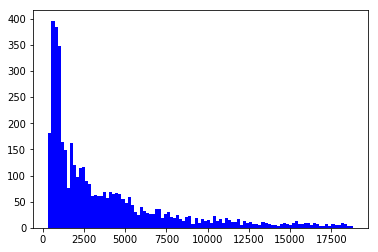

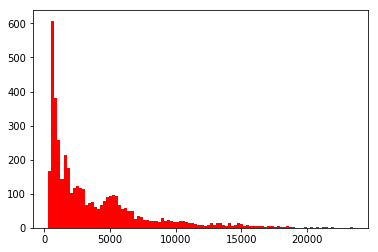

In [32]:
print("MSE: %.3f" % metrics.mean_squared_error(y_val, y_pred))
print("MAE: %.3f" % metrics.mean_absolute_error(y_val, y_pred))
print('R2: %.3f' % metrics.r2_score(y_val, y_pred))

plt.hist(y_val, bins=100, color='blue', linewidth=3)
plt.show()
plt.hist(y_pred, bins=100, color='red', linewidth=3)
plt.show()

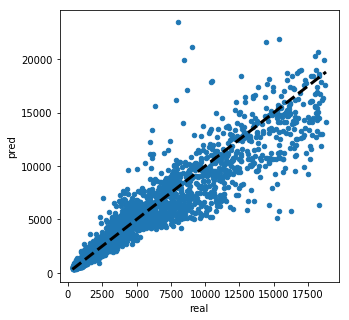

In [33]:
df = pd.DataFrame({'real': y_val, 'pred': y_pred})
ax = df.sort_values('real').plot.scatter('real', 'pred', figsize=(5, 5))
_ = ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)

In [34]:
def oneHotEncoding(features,columnName):
	currentCol = features.columns.get_loc(columnName)
	uniqueFeatures = features[columnName].unique()
	print(uniqueFeatures)
	for f in range(len(uniqueFeatures)):
		features.insert(loc=currentCol+f,column=columnName+str(f),value=0)
		features[columnName+str(f)][features[columnName]==uniqueFeatures[f]] = 1
		
	features.pop(columnName)

def dummieCoding(features,columnName,orderedFeature):
	c = 0
	for f in range(len(orderedFeature)):
		features[columnName][features[columnName]==orderedFeature[f]] = 2**c
		c = c + 1

In [35]:
def RMSE(theta,X,y):
	y_linha = hypothesis(theta,X)
	error = math.sqrt(((y_linha-y)**2).mean())
	return error

#
#  For linear regression, it is possible to estimate the values
# of all parameters theta by applying the normal equation method,
# which corresponds to the following equation:
#
#  Theta = (Xt.X)^-1.Xt.y
#
#  This procedure is called Normal Equation, which is implemented
# here
#
# params:
#   X -> set of features
#   Y -> set of targets
#
# return:
#   theta -> set of parameters
#
def normalEquation(X,y):
	X = np.insert(X,0,1,axis=1)
	npX = np.copy(X)
	npY = y.transpose()
	npXt = npX.transpose()

	R1 = np.matmul(npXt,npX)

	det = np.linalg.det(R1)

	if (det != 0):
		R1 = np.linalg.inv(R1)
		R2 = np.matmul(npXt,npY)
		theta = np.matmul(R1,R2)
	else:
		theta = []
		print("Error! Matrix (Xt.X) has no inverse.")

	error = RMSE(theta,X,y)
	print("Normal Equation --- RMSE error: ",str(error))

	X = np.delete(X,0,axis=1)

	return theta

In [36]:
theta = np.array([1, 0, 1], dtype=np.double)
theta_temp = np.array([0, 0, 0], dtype=np.double)
y = np.array([5.,10.], dtype=np.double)
X = np.array([[0.,1., 2.],[0.,2., 3.]], dtype=np.double)
print (X)
alpha = .01
max_iter = 50

[[0. 1. 2.]
 [0. 2. 3.]]


In [37]:
def hyphotesis(theta, X):
    return np.sum(theta.T * X, axis=1)
    
def MSE_theta(theta, X, y, alpha,j, h0, error):                
        S = np.sum(np.matmul(error, X[:,j]))                
        result = theta[j] - (alpha * (1. / len(y)) * S)        
        return result

for i in range(max_iter):
    h0 = hyphotesis(theta, X)
    error = (h0 - y)
    for j in range(X.shape[1]):
        theta_temp[j] = MSE_theta(theta, X, y, alpha, j, h0, error)    
        
    theta = theta_temp.copy()
    print (theta)    

hyphotesis(theta, X)

[1.    0.085 1.135]
[1.       0.162475 1.257825]
[1.         0.23310013 1.36956737]
[1.         0.29748993 1.47122149]
[1.         0.35620382 1.5636925 ]
[1.         0.40975102 1.64780433]
[1.         0.45859507 1.72430701]
[1.         0.50315792 1.79388325]
[1.         0.54382364 1.85715452]
[1.         0.58094187 1.91468653]
[1.         0.61483086 1.96699423]
[1.         0.64578032 2.01454637]
[1.         0.67405396 2.05776965]
[1.         0.69989182 2.09705246]
[1.         0.72351243 2.13274838]
[1.         0.74511468 2.16517924]
[1.         0.76487964 2.194638  ]
[1.         0.78297213 2.22139134]
[1.         0.79954218 2.24568202]
[1.         0.81472634 2.267731  ]
[1.         0.82864894 2.28773943]
[1.         0.84142314 2.30589041]
[1.         0.85315195 2.32235061]
[1.         0.86392912 2.33727174]
[1.         0.87384003 2.35079191]
[1.         0.88296235 2.36303684]
[1.         0.89136682 2.37412095]
[1.         0.89911781 2.38414842]
[1.         0.90627393 2.39321406]
[1.   

array([5.91038925, 9.35683622])

In [38]:
import math

import math


def SGD_(alpha, max_iter, X, y):
    
    # Creating theta0 
    X = np.insert(X, values=1, obj=0, axis=1)
    
    shape = X.shape
    nsamples = shape[0]
    print("Number of samples: "+str(nsamples))
    theta0 = np.zeros(nsamples)
    nparams = shape[1]
    print("Number of parameters: "+str(nparams))


    theta = np.random.uniform(size=nparams)
    theta_temp = np.ones(nparams)

    error = 1
    epsilon = 0.001
    it = 0
    i = 0   
    power_t = 0.25
    t=1.0
    
    while ((error > epsilon) and (it < max_iter)):
        h0 = hyphotesis(theta, X)
        eta = alpha / pow(t, power_t)
        error = (h0 - y)
        for j in range(nparams):
            theta_temp[j] = MSE_theta(theta, X, y, eta, j, h0, error)                
        it += 1
        i += 1
        y_pred = hyphotesis(theta_temp, X)
#         print (y,hyphotesis(theta_temp, X))
        error =  ((y - y_pred) ** 2).mean() / 2 
#         print(theta)
#         print(theta_temp)

        theta = theta_temp.copy()
        
        if (i % 100) == 0 or i == 1:
            print("Epoch: %s Batch: %s Error: %.8f lr: %.8f "%(it, i, error, eta))
        t += 1            
   
    return theta
def predict(theta, X):
    X = np.insert(X, values=1, obj=0, axis=1)
    return hyphotesis(theta_h, X)

max_iter = 10000
theta_h = SGD_(alpha, max_iter, X, y)
print (y,predict(theta_h, X))


Number of samples: 2
Number of parameters: 4
Epoch: 1 Batch: 1 Error: 6.67350207 lr: 0.01000000 
Epoch: 100 Batch: 100 Error: 0.42147102 lr: 0.00316228 
Epoch: 200 Batch: 200 Error: 0.40196298 lr: 0.00265915 
Epoch: 300 Batch: 300 Error: 0.38694104 lr: 0.00240281 
Epoch: 400 Batch: 400 Error: 0.37364296 lr: 0.00223607 
Epoch: 500 Batch: 500 Error: 0.36157525 lr: 0.00211474 
Epoch: 600 Batch: 600 Error: 0.35046165 lr: 0.00202052 
Epoch: 700 Batch: 700 Error: 0.34012462 lr: 0.00194413 
Epoch: 800 Batch: 800 Error: 0.33044049 lr: 0.00188030 
Epoch: 900 Batch: 900 Error: 0.32131819 lr: 0.00182574 
Epoch: 1000 Batch: 1000 Error: 0.31268788 lr: 0.00177828 
Epoch: 1100 Batch: 1100 Error: 0.30449428 lr: 0.00173641 
Epoch: 1200 Batch: 1200 Error: 0.29669256 lr: 0.00169904 
Epoch: 1300 Batch: 1300 Error: 0.28924564 lr: 0.00166538 
Epoch: 1400 Batch: 1400 Error: 0.28212230 lr: 0.00163481 
Epoch: 1500 Batch: 1500 Error: 0.27529594 lr: 0.00160686 
Epoch: 1600 Batch: 1600 Error: 0.26874359 lr: 0.001

In [39]:
max_iter = 10000
theta_h = SGD_(1., max_iter=max_iter, X=X_train, y=np.log(y_train.values))


Number of samples: 38822
Number of parameters: 12
Epoch: 1 Batch: 1 Error: 1.87766050 lr: 1.00000000 
Epoch: 100 Batch: 100 Error: 0.03288123 lr: 0.31622777 
Epoch: 200 Batch: 200 Error: 0.02832026 lr: 0.26591479 
Epoch: 300 Batch: 300 Error: 0.02725996 lr: 0.24028114 
Epoch: 400 Batch: 400 Error: 0.02694488 lr: 0.22360680 
Epoch: 500 Batch: 500 Error: 0.02683367 lr: 0.21147425 
Epoch: 600 Batch: 600 Error: 0.02678741 lr: 0.20205155 
Epoch: 700 Batch: 700 Error: 0.02676426 lr: 0.19441308 
Epoch: 800 Batch: 800 Error: 0.02675012 lr: 0.18803015 
Epoch: 900 Batch: 900 Error: 0.02673980 lr: 0.18257419 
Epoch: 1000 Batch: 1000 Error: 0.02673126 lr: 0.17782794 
Epoch: 1100 Batch: 1100 Error: 0.02672365 lr: 0.17364082 
Epoch: 1200 Batch: 1200 Error: 0.02671658 lr: 0.16990442 
Epoch: 1300 Batch: 1300 Error: 0.02670988 lr: 0.16653831 
Epoch: 1400 Batch: 1400 Error: 0.02670345 lr: 0.16348127 
Epoch: 1500 Batch: 1500 Error: 0.02669725 lr: 0.16068568 
Epoch: 1600 Batch: 1600 Error: 0.02669124 lr: 

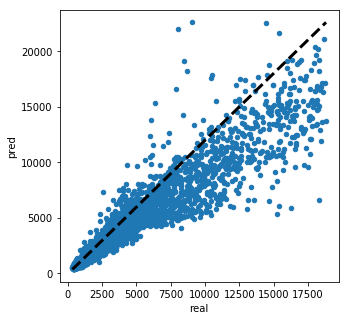

In [40]:
y_pred = np.exp(predict(theta_h, X_val))

df = pd.DataFrame({'real': y_val, 'pred': y_pred})
ax = df.sort_values('real').plot.scatter('real', 'pred', figsize=(5, 5))
_ = ax.plot([y_val.min(), y_val.max()], [y_pred.min(), y_pred.max()], 'k--', lw=3)



In [41]:
np.mean((np.log(y_pred) - np.log(y_val.values))**2)

0.05226091970175411

In [42]:
np.mean((y_pred - y_val.values)**2)

1783160.1686528998

MSE: 1783160.169
MAE: 707.556
R2: 0.889


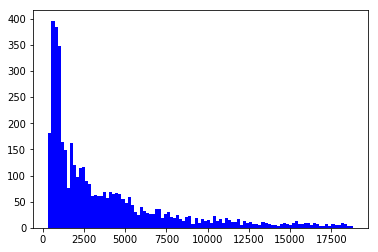

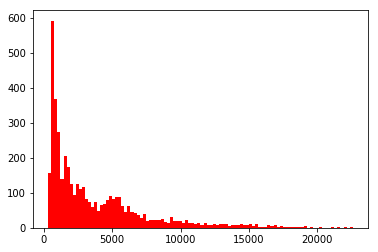

In [43]:
print("MSE: %.3f" % metrics.mean_squared_error(y_val, y_pred))
print("MAE: %.3f" % metrics.mean_absolute_error(y_val, y_pred))
print('R2: %.3f' % metrics.r2_score(y_val, y_pred))

plt.hist(y_val, bins=100, color='blue', linewidth=3)
plt.show()
plt.hist(y_pred, bins=100, color='red', linewidth=3)
plt.show()